Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [30]:
# # Install a pip package in the current Jupyter kernel 🚨RUN THIS CELL ONCE FOR YOUR ENVIRONMENT
# import sys
# !"{sys.executable}" -m pip install "aerosandbox[full]"
# !"{sys.executable}" -m pip install "gymnasium[all]"
# !"{sys.executable}" -m pip install "stable_baselines3[extra]"
# !"{sys.executable}" -m pip install "tensorboard"

Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [31]:
#Helper
import random
import aerosandbox.numpy as np
def flatten_list(nested_item):
    flattened = []
    
    if isinstance(nested_item, (list, np.ndarray)):
        for item in nested_item:
            flattened.extend(flatten_list(item))
    else:
        flattened.append(nested_item)
    
    return flattened

def offsetsToLocations(offsets, minXGap):
    # Initialize an empty list to store the resulting locations
    locations = []
    # Initialize the starting location
    previous_location = [0, 0, 0]
    current_location = [0, 0, 0]
    
    # Iterate through each offset in the list
    for offset in offsets:
        locations.append(current_location.copy())
        previous_location = current_location.copy()
        current_location = [
            current_location[0] + offset[0],
            current_location[1] + offset[1],
            current_location[2] + offset[2],
        ]
        if(current_location[1] - previous_location[1] < minXGap):
            current_location[1] = previous_location[1] + minXGap
        
    
    return locations

def locationsToOffsets(locations):
    # Initialize an empty list to store the resulting offsets
    offsets = []
    
    # Initialize the previous location
    prev_location = [0, 0, 0]
    
    # Iterate through each location in the list
    for location in locations:
        # Calculate the offset as the difference between the current and previous locations
        offset = [location[i] - prev_location[i] for i in range(3)]
        
        # Append the offset to the list of offsets
        offsets.append(offset)
        
        # Update the previous location for the next iteration
        prev_location = location
    
    return offsets

In [32]:
import math
import aerosandbox as asb
import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):

	# construct and save self.airplane from self.xsecs
	def constructAirplane(self):
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=False,
					xsecs=self.xsecs
				)],
		)
	
	#attempting to constraint reward
	def getReward(self):
		lift = self.aero["L"]
		drag = self.aero["D"]
		torque = self.aero["M_g"][2]

		#Low drag is great even if lift ends up being downforce.
		if(lift < 0):
			reward = -20
		else:
			reward = abs(lift/drag)

		#Minimize torque means a slimmer wing on its length
		torquePenalty = math.log(abs(self.aero["M_g"][2]),5)
		reward = reward - torquePenalty
		
		reward = reward*(self.currStep/self.episodeSteps)**2

		#Is torque sucking the wing forward magically? Drag? 0 reward.
		if(drag < 0 or self.aero["M_g"][2] > 0):
			reward = -50
		
		#final constraints, to prevent insanely negative rewards
		reward = max(reward, -50)
		reward = min(reward, 150)
		
		torqueStr = f"Torque on Z: {round(torque, 2)}"
		torqueStrLog = f"Torque Penalty: {round(torquePenalty, 2)}"
		liftStr = f"Lift: {round(lift, 3)}"
		dragStr = f"Drag: {round(drag, 3)}"
		lift_drag = f"Lift/Drag: {round(lift/drag,3)}"
		step = f"Step: {self.currStep}/{self.episodeSteps}"
		reward_str = f"Reward: {round(reward,3)}"

		output = "\n".join([torqueStr, torqueStrLog, liftStr, dragStr, lift_drag, step, reward_str])
		print(output)
		return reward

	# construct and safe self.vlm()
	def runAero(self):
		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			),
		)
		# self.vlm.run_symmetric = True
		self.aero = self.vlm.run()
	
	def get_observation_vector(self):
		obs = []
		for xsec in self.xsecs:
			# xyz_le is a list of three values
			obs.extend(xsec.xyz_le)
			
			# chord and twist are single values
			obs.append(xsec.chord)
			obs.append(xsec.twist)

			# KulfanAirfoil attributes
			# Both upper_weights and lower_weights are numpy arrays
			obs.extend(xsec.airfoil.upper_weights.tolist())
			obs.extend(xsec.airfoil.lower_weights.tolist())

			# leading_edge_weight, N1, and N2 are single values
			obs.append(xsec.airfoil.leading_edge_weight)
			obs.append(xsec.airfoil.N1)
			obs.append(xsec.airfoil.N2)
		# Append aerodynamics output at the end
		# - 'F_g' : an [x, y, z] list of forces in geometry axes [N]
		# - 'F_b' : an [x, y, z] list of forces in body axes [N]
		# - 'F_w' : an [x, y, z] list of forces in wind axes [N]
		# - 'M_g' : an [x, y, z] list of moments about geometry axes [Nm]
		# - 'M_b' : an [x, y, z] list of moments about body axes [Nm]
		# - 'M_w' : an [x, y, z] list of moments about wind axes [Nm]
		# - 'L' : the lift force [N]. Definitionally, this is in wind axes.
		# - 'Y' : the side force [N]. This is in wind axes.
		# - 'D' : the drag force [N]. Definitionally, this is in wind axes.
		# - 'l_b', the rolling moment, in body axes [Nm]. Positive is roll-right.
		# - 'm_b', the pitching moment, in body axes [Nm]. Positive is pitch-up.
		# - 'n_b', the yawing moment, in body axes [Nm]. Positive is nose-right.
		# - 'CL', the lift coefficient [-]. Definitionally, this is in wind axes.
		# - 'CY', the sideforce coefficient [-]. This is in wind axes.
		# - 'CD', the drag coefficient [-]. Definitionally, this is in wind axes.
		# - 'Cl', the rolling coefficient [-], in body axes
		# - 'Cm', the pitching coefficient [-], in body axes
		# - 'Cn', the yawing coefficient [-], in body axes
		drag = self.aero["D"]
		lift = self.aero["L"]
		drag = np.tanh((drag-50)/50)
		lift = np.tanh((lift-50)/50)
		obs.append(lift)
		obs.append(drag)
		obs.append(self.currStep)
		return np.array(obs, dtype=np.float32)
	
	def __init__(self, 
			  # === Key Parameters ===
			  episodeSteps,
			  kulfanWeightResolution, 	#How many kulfan weights per XSec? More = more intricate designs. Something like 5-8 should be enough...
			  numChords, 				#How many independently controlled foils along length of wing 
			  minChordSpacing,
			  minChordLength,

			  # === Initial Values ===
			  initialYSpacing, 			#Initial spacing of the cross sections
			  initialChordLength, 		#Initial length from front to back of each cross section in wing
			  initialUpperKulfan, 		#Upper kulfan weight initial values (controls curvature of top of wing)
			  initialLowerKulfan, 		#Lower Kulfan weight initial values (controls curvature of bottom of wing)
			  initialLEW, 				#Leading edge weight initial values
			  initialN1, 				#Initial N1 value (forward shift of wing curve shape)
			  initialN2, 				#Initial N2 value (backwards shift of wing curve shape)
			  
			  # === Changing Values ===
			  dX_bounds, 				#How much to allow shift of each cross section per time step in forward/backwards direction
			  dY_bounds, 				#How much to allow shift of each cross section per time step in left/right direction (stubbier wings)
			  dZ_bounds, 				#How much to allow shift of each cross section per time step in up/down direction (wingtips?)
			  dChord_bounds, 			#How much to allow each cross section to change in length per timestep (wider wings? front-back length)
			  dTwist_bounds, 			#How much (in DEGREES) to allow rotation of each cross section per timestep about leading edge
			  KT_bounds, 				#Min/max upper kulfan weights (should be 0,>0)
			  KB_bounds, 				#Max lower kulfan weights (should be <0,0 unless you want to create gaps on bottom of wing that arc up)
			  N_bounds, 				#Bounds of either N value (1, ?)
			  LEW_bounds, 				#Bounds of leading edge weight (??? TODO: Learn what the fuck this does lmao. Experiment)
		):
		super(AeroEnv, self).__init__() #Initialize gym enviro
		self.numChords = numChords
		self.kulfanWeightResolution = kulfanWeightResolution
		self.minChordSpacing = minChordSpacing
		self.minChordLength = minChordLength
		self.episodeSteps = episodeSteps
		
		# Lower and upper bounds for each of the parameters
		low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
		high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
		self.vectorLengthPerXSec = len(low)
		# Creates a much bigger vector, action bounds PER cross section.
		oLow = low.copy()
		oHigh = high.copy()
		low = np.tile(low, numChords) 
		high = np.tile(high, numChords)

		# === Establish bounds for leading edges === 
		oLow[0]=oLow[0]*episodeSteps + 0 # 0 here is the initial value min
		oLow[1]=0 # 0 here is the initial value min
		oLow[2]=oLow[2]*episodeSteps + 0 # 0 here is the initial value min

		oHigh[0]=oHigh[0]*episodeSteps + 0 # 0 here is the initial value max
		oHigh[1]=oHigh[1]*episodeSteps*numChords # initial value max is gonna be the farthest chord out
		oHigh[2]=oHigh[2]*episodeSteps + 0 # 0 here is the initial value max

		# === Establish bounds for CHORD and TWIST === 
		oLow[3]=oLow[3]*episodeSteps + initialChordLength 
		oLow[4]=oLow[4]*episodeSteps + 0 

		oHigh[3]=oHigh[3]*episodeSteps + initialChordLength
		oHigh[4]=oHigh[4]*episodeSteps + 0

		# === Establish KT / KB weight bounds, N bounds, LEW bounds ===
		# No need because absolute value, so bounds are same as action bounds

		oLow = np.tile(oLow, numChords) 
		oHigh = np.tile(oHigh, numChords)

		# === Establish Aerodynamic Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, [-1, -1]) #Lift, Drag: I intend to use tanH
		oHigh = np.append(oHigh, [1, 1]) #Lift, Drag: I intend to use tanH		

		# === Establish Episode Bounds (AFTER tiling because not 1 per chord) ===
		oLow = np.append(oLow, 0) 
		oHigh = np.append(oHigh, episodeSteps) 	

		self.observation_space = spaces.Box(low=oLow, high=oHigh, dtype=np.float32) #there are 18 additional values provided by vlm.run(), but Im just using 2, Lift and Drag
		self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		

		# Initial values for cross sections
		self.init_xyz_le_offsets = [[0, initialYSpacing, 0]]*self.numChords
		self.init_chord = [initialChordLength] * self.numChords  														
		self.init_twist = [0] * self.numChords  														
		self.init_upper_weights = [np.array([initialUpperKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_lower_weights = [np.array([initialLowerKulfan] * self.kulfanWeightResolution,np.float32) for _ in range(self.numChords)]
		self.init_leading_edge_weight = [initialLEW] * self.numChords  										
		self.init_N1 = [initialN1] * self.numChords 															
		self.init_N2 = [initialN2] * self.numChords


		self.init_xyz_le = offsetsToLocations(self.init_xyz_le_offsets, minXGap=self.minChordSpacing)
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i],
			)
		) for i in range(self.numChords)]
		self.constructAirplane()
		self.currStep = 0
		
	def step(self, action):
		self.currStep += 1
		#Turn chord positions into offsets
		currPos=[]
		for i in range(self.numChords):
			# Apply dX, dY, dZ
			currPos.append([
				self.xsecs[i].xyz_le[0],
				self.xsecs[i].xyz_le[1],
				self.xsecs[i].xyz_le[2]
			])
		
		offsets = locationsToOffsets(currPos)
		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			# Apply dX, dY, dZ
			offsets[i] = [
				offsets[i][0] + action[idx], 		#x + dx
				offsets[i][1] + action[idx + 1],	#y + dy
				offsets[i][2] + action[idx + 2]		#z + dz
			]
		
		newXYZ_le_positions = offsetsToLocations(offsets, minXGap=self.minChordSpacing)

		for i in range(self.numChords):
			idx = i * self.vectorLengthPerXSec
			newXYZ_le = newXYZ_le_positions[i]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(self.kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+self.kulfanWeightResolution + j] for j in range(self.kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*self.kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*self.kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*self.kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le=([0,0,0] if i == 0 else newXYZ_le), #might not be needed
				chord=max(newChord, self.minChordLength),
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		self.constructAirplane()
		self.runAero()
		
		obs = self.get_observation_vector()				# observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
		reward = self.getReward()						# reward (SupportsFloat): The reward as a result of taking the action.
		terminated = self.currStep == self.episodeSteps	# terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
		truncated = False	 							# truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
		info = {"lift": self.aero["L"], "drag": self.aero["L"]}	# info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
		
		return obs, reward, terminated, truncated, info 
    
	def reset(self, seed=random.randint(1, 9999)):
		super().reset(seed=seed)
		print("Reset was called!")
		self.currStep = 0
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(self.numChords)]

		randomAction = self.action_space.sample()
		self.step(randomAction)

		self.constructAirplane()
		self.runAero()
		
		liftCoeff = self.aero["CL"]
		dragCoeff = self.aero["CD"]

		obs = self.get_observation_vector()
		info = {"lift": liftCoeff, "drag": dragCoeff} 
		return obs, info
	
	def render(self):
		self.runAero()
		self.airplane.draw_three_view()
		# self.vlm.draw()
	
	def close (self):
		...

In [33]:
steps = 5 #steps per episode used in model training before resetting

def make_env():
    def _init():
        env = AeroEnv(
            episodeSteps=steps,
            numChords=4, 
            minChordLength=0.2,
            minChordSpacing=0.3,
            initialYSpacing=1, 
            initialChordLength=1, 
            initialUpperKulfan=1, 
            initialLowerKulfan=-0.3, 
            initialLEW=0.1, 
            initialN1=1, 
            initialN2=1, 
            dX_bounds = (-1, 1),
            dY_bounds = (-2, 2),
            dZ_bounds = (0, 0),
            dChord_bounds = (-0.5, 0.5),
            dTwist_bounds = (-5, 5),
            KT_bounds = (0, 1),
            KB_bounds = (-1, 0),
            N_bounds = (1, 3),
            LEW_bounds = (0, 0.6),
            kulfanWeightResolution = 5
        )
        return env
    return _init

Reset was called!
Torque on Z: -19485554.75
Torque Penalty: 10.43
Lift: 51433.266
Drag: 9693527.487
Lift/Drag: 0.005
Step: 1/5
Reward: -0.417


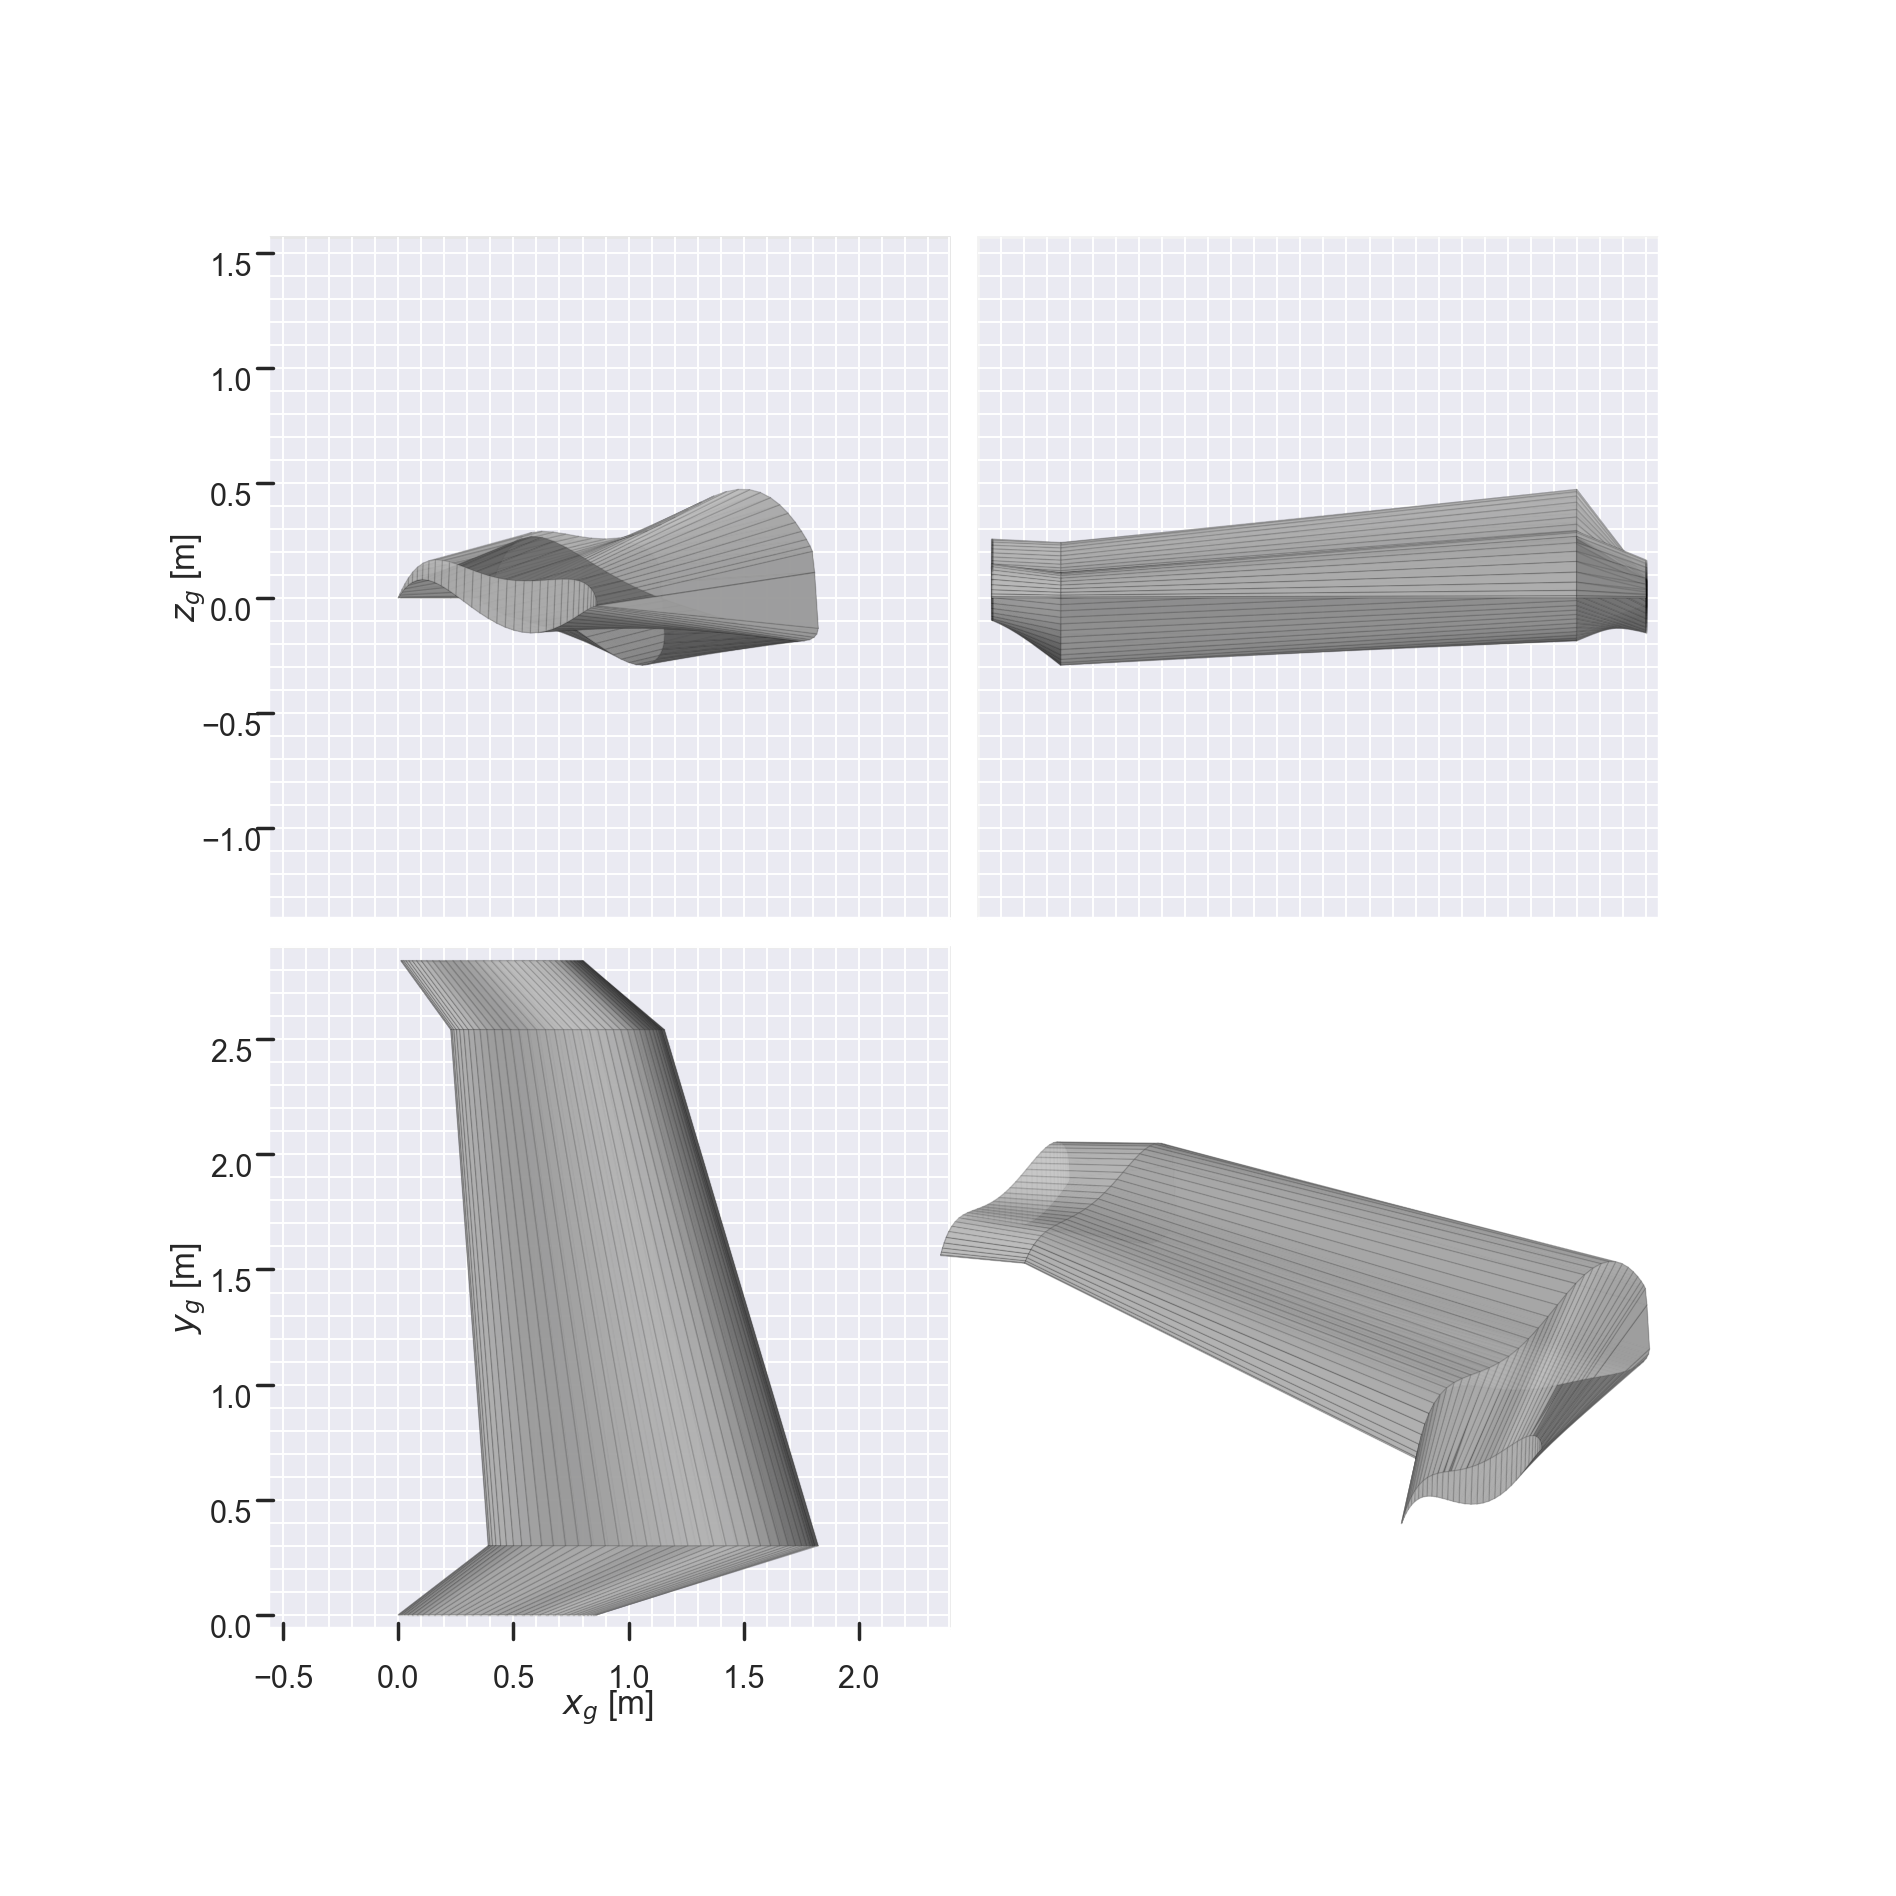

Torque on Z: -14689276.78
Torque Penalty: 10.25
Lift: 178113.2
Drag: 29648819.49
Lift/Drag: 0.006
Step: 2/5
Reward: -1.64


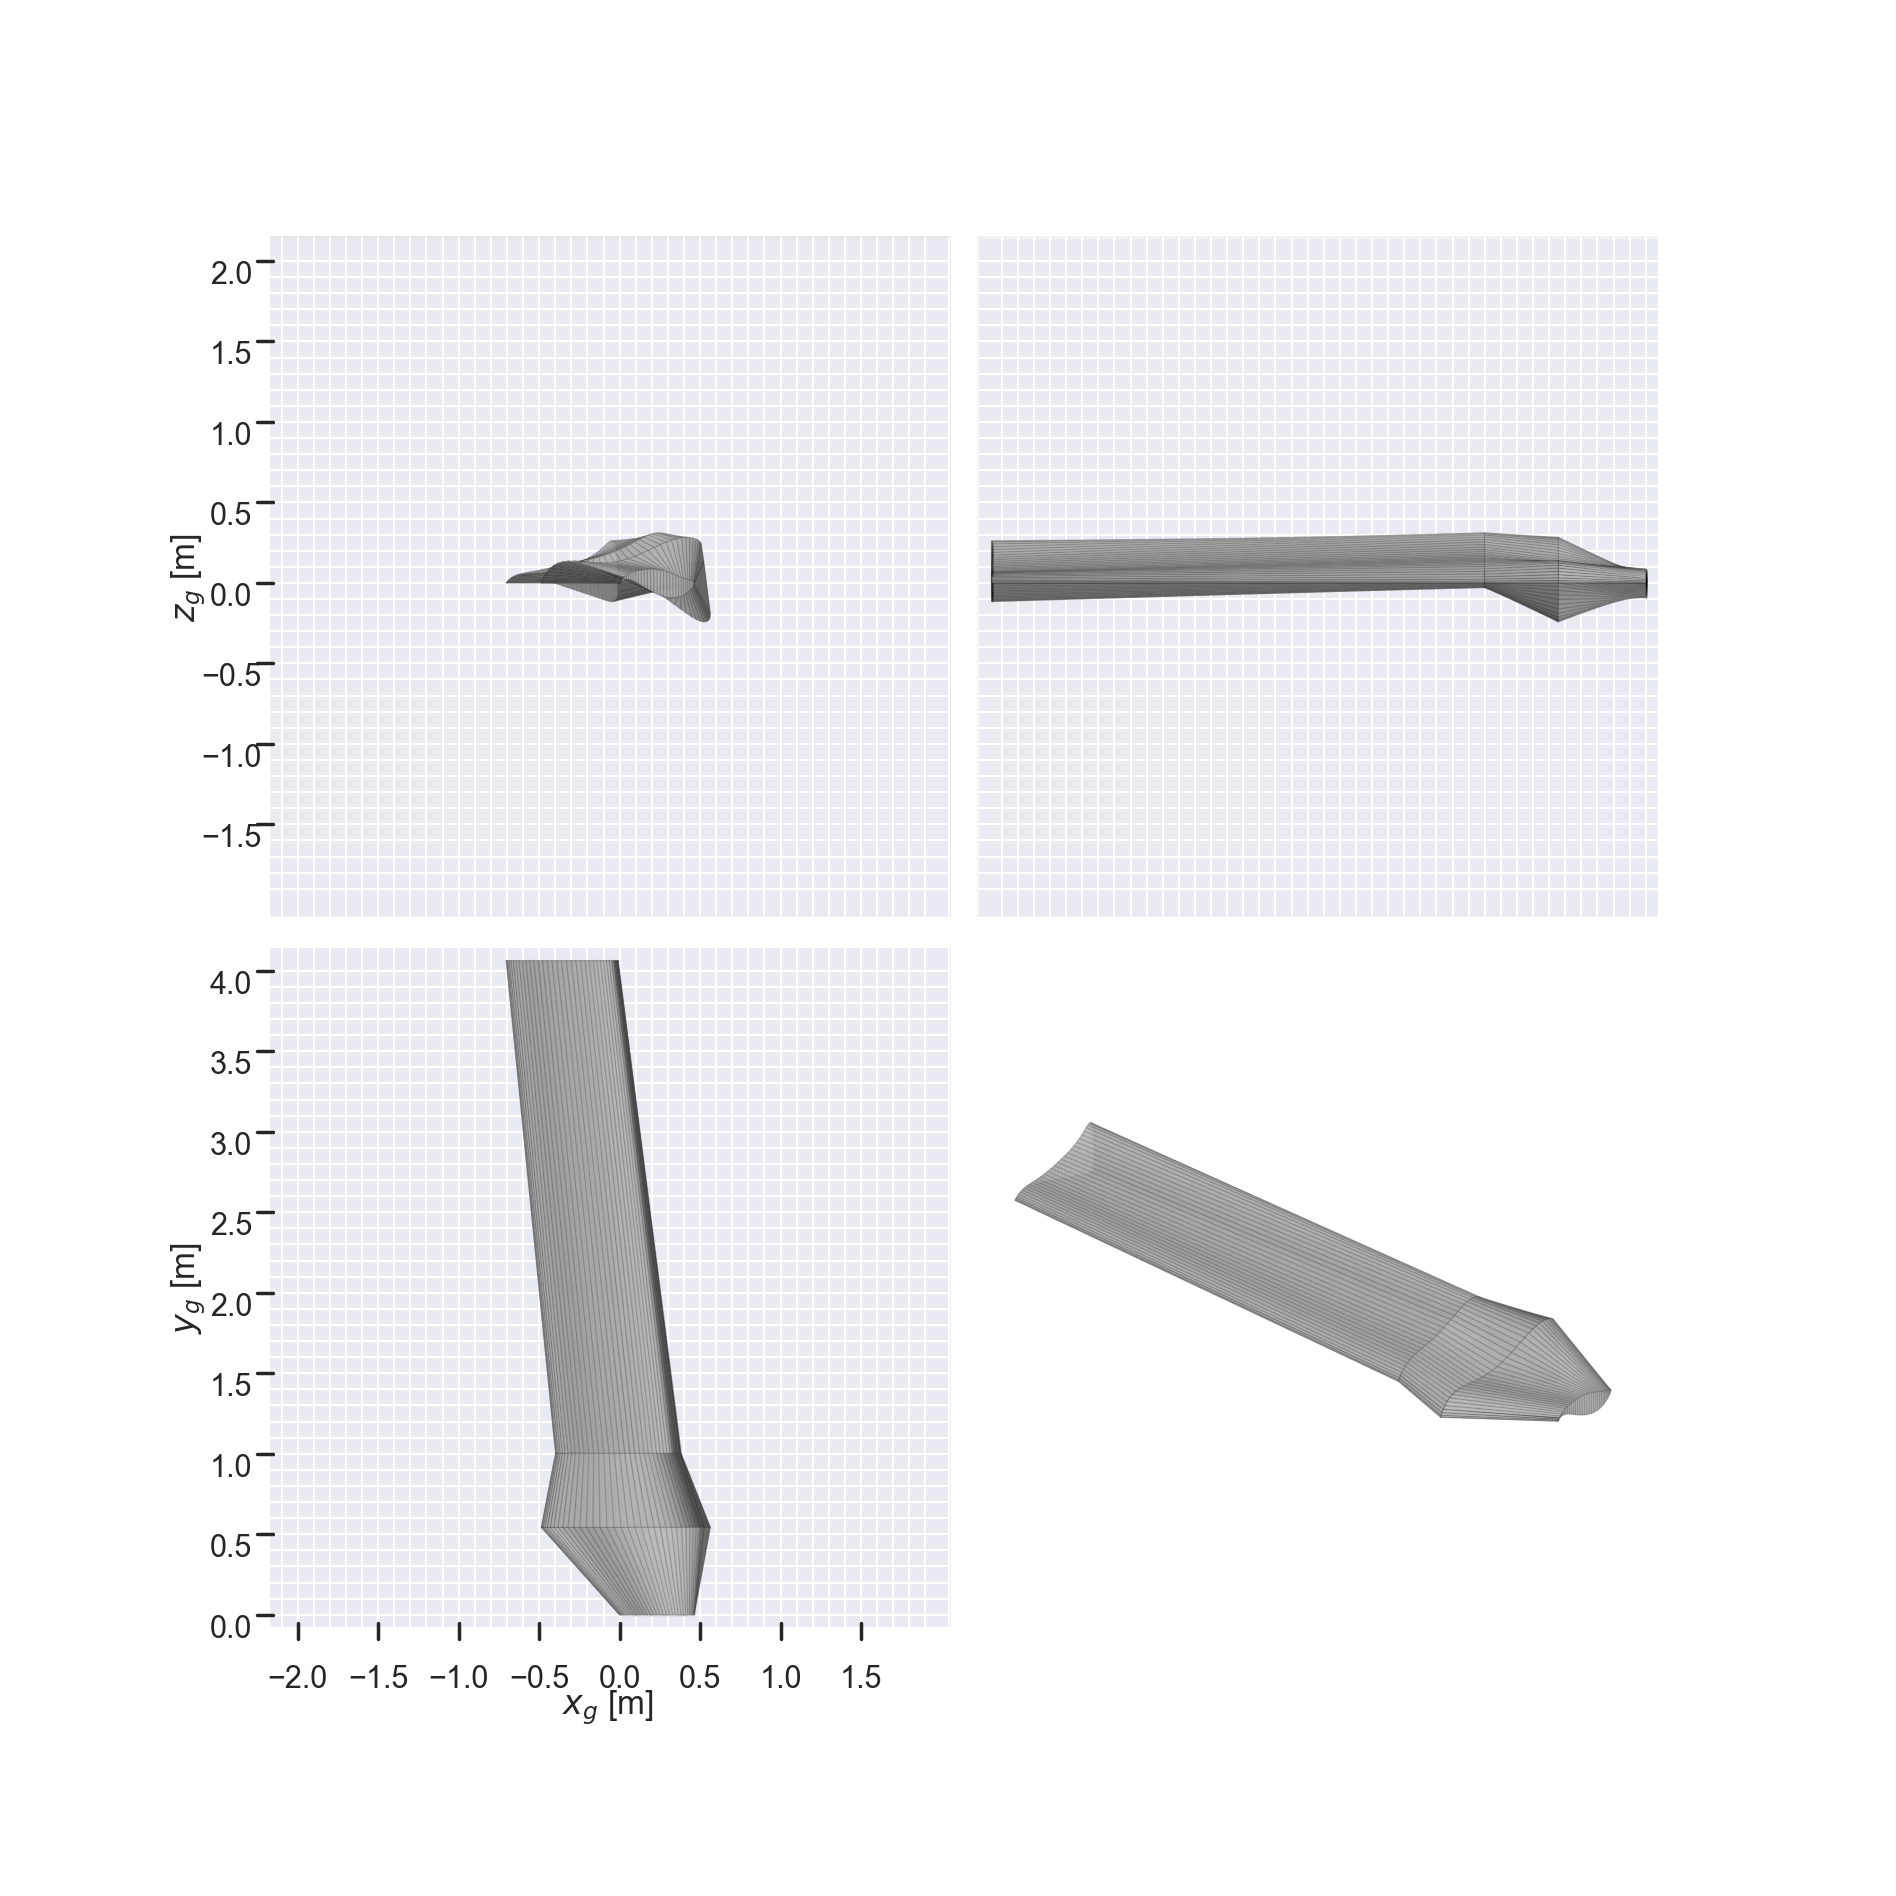

In [34]:
# ##SanityCheck
env = make_env()()

obs = env.reset()
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()

random_action = env.action_space.sample()
env.step(random_action)
env.render()


In [28]:
from stable_baselines3 import PPO
import os
import time
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3.common.vec_env import VecNormalize
import copy

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

# envs = [make_env() for _ in range(3)]
# env = DummyVecEnv(envs)
# env = VecNormalize(env)
env = make_env()()
# evalEnv = copy.deepcopy(env)
# eval_callback = EvalCallback(
#     eval_env=evalEnv, 
#     best_model_save_path='./logs/best_model/',
#     log_path='./logs/eval_log/', 
#     eval_freq=1000)

# TODO: find a way to use eval callback that doesnt add 10 minutes per eval to the run

model = PPO(
	n_steps=steps,
    batch_size=steps,
	policy="MlpPolicy",
	env=env,
    n_epochs=10,
    learning_rate=.001,
	verbose=0,
    tensorboard_log=logdir,
    stats_window_size=steps,
)

env.render()

total_timesteps = 3000
model.learn(total_timesteps=total_timesteps)

print("We lerned")

Torque on Z: -507.92
Torque Penalty: 3.87
Lift: 682.082
Drag: 297.684
Lift/Drag: 2.291
Step: 2/5
Reward: -0.253
Torque on Z: 17302.99
Torque Penalty: 6.06
Lift: -4921.881
Drag: 7813.222
Lift/Drag: -0.63
Step: 3/5
Reward: -50
Torque on Z: -153.13
Torque Penalty: 3.13
Lift: 18.268
Drag: 40.803
Lift/Drag: 0.448
Step: 4/5
Reward: -1.714
Torque on Z: -83.53
Torque Penalty: 2.75
Lift: 46.118
Drag: 32.994
Lift/Drag: 1.398
Step: 5/5
Reward: -1.352
Reset was called!
Torque on Z: -22515.29
Torque Penalty: 6.23
Lift: -3170.298
Drag: 13844.503
Lift/Drag: -0.229
Step: 1/5
Reward: -1.049
Torque on Z: -1465.96
Torque Penalty: 4.53
Lift: 569.22
Drag: 505.873
Lift/Drag: 1.125
Step: 2/5
Reward: -0.545
Torque on Z: -86.71
Torque Penalty: 2.77
Lift: -439.194
Drag: 41.641
Lift/Drag: -10.547
Step: 3/5
Reward: -8.198
Torque on Z: -188094971.39
Torque Penalty: 11.84
Lift: 2641050.972
Drag: 56283347.264
Lift/Drag: 0.047
Step: 4/5
Reward: -7.546
Torque on Z: 573746590.65
Torque Penalty: 12.53
Lift: -341457244.9

Reset was called!
Torque on Z: -570266554.19
Torque Penalty: 12.53
Lift: -58973143.044
Drag: 284818317.746
Lift/Drag: -0.207
Step: 1/5
Reward: -1.301
0
Torque on Z: -123.83
Torque Penalty: 2.99
Lift: 578.151
Drag: 83.109
Lift/Drag: 6.957
Step: 2/5
Reward: 0.634
1
Torque on Z: -64.97
Torque Penalty: 2.59
Lift: 330.395
Drag: 13.044
Lift/Drag: 25.33
Step: 3/5
Reward: 8.185
2
Torque on Z: -64.44
Torque Penalty: 2.59
Lift: 686.904
Drag: 20.508
Lift/Drag: 33.494
Step: 4/5
Reward: 19.78
3
Torque on Z: -206.6
Torque Penalty: 3.31
Lift: 679.486
Drag: 33.881
Lift/Drag: 20.055
Step: 5/5
Reward: 16.743
4
Torque on Z: -298.6
Torque Penalty: 3.54
Lift: 773.702
Drag: 35.959
Lift/Drag: 21.516
Step: 6/5
Reward: 25.884
===






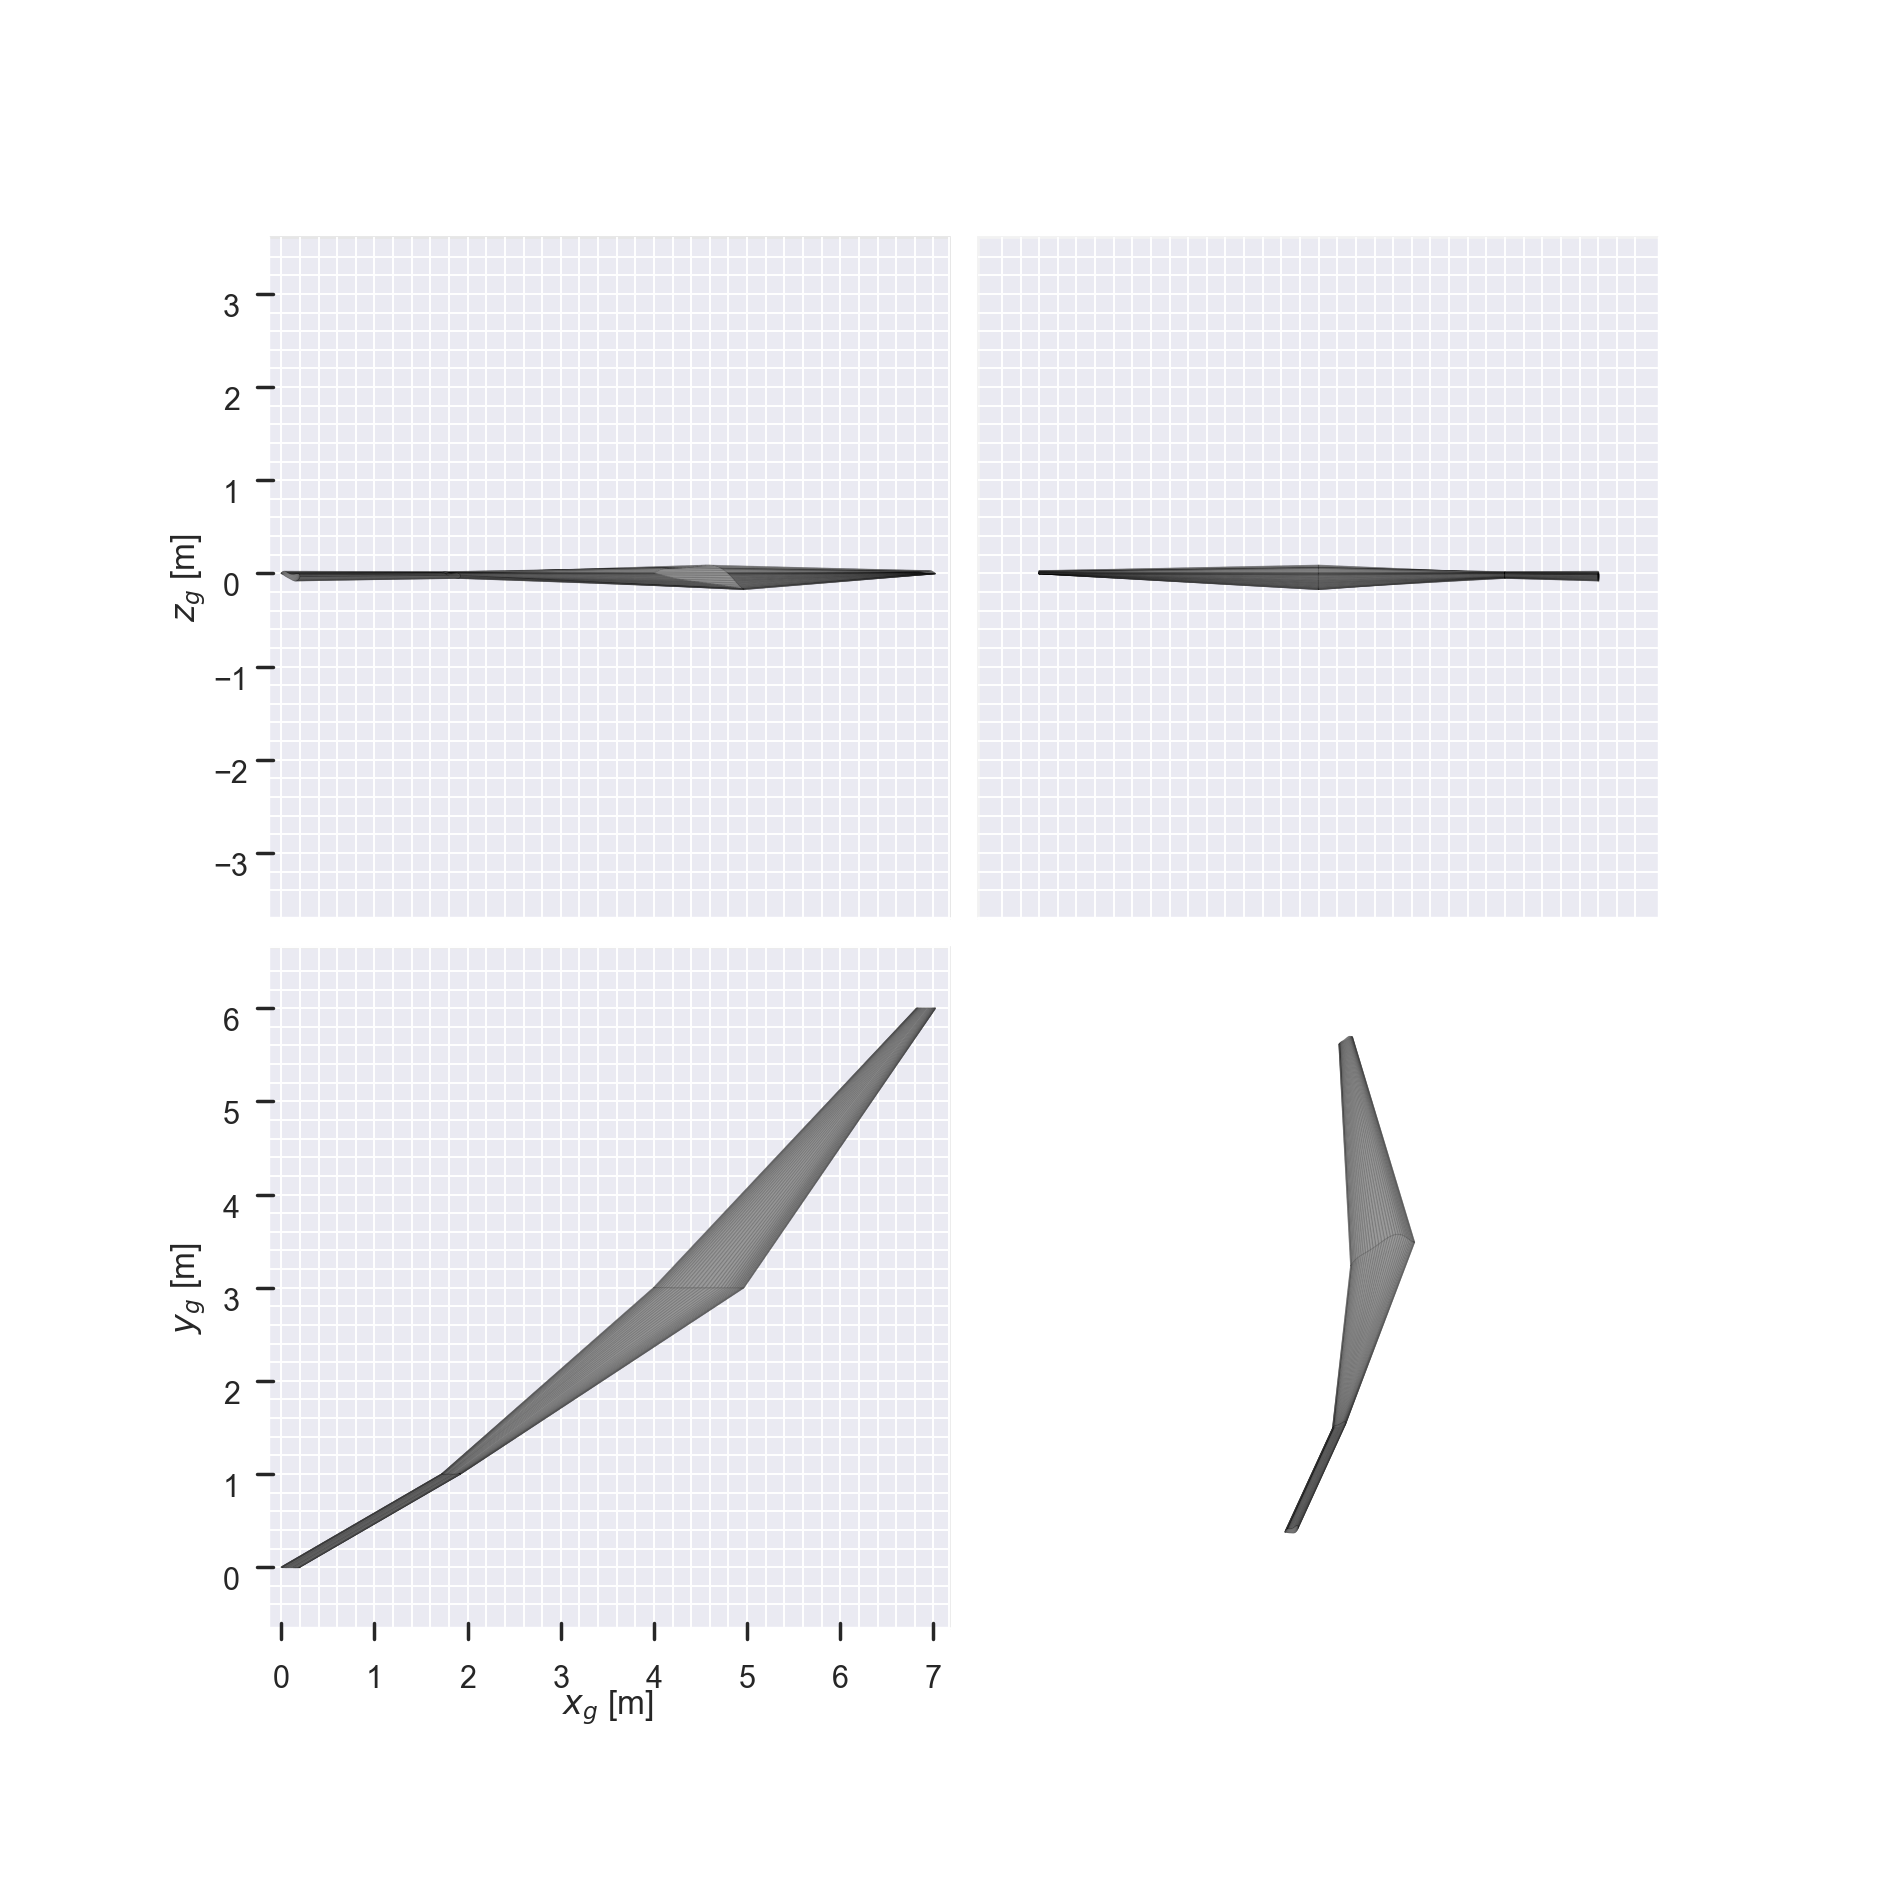

Reset was called!
Torque on Z: -705.21
Torque Penalty: 4.08
Lift: 265.273
Drag: 861.957
Lift/Drag: 0.308
Step: 1/5
Reward: -0.151
Reset was called!
Torque on Z: -1056361.2
Torque Penalty: 8.62
Lift: 163045.788
Drag: 234214.102
Lift/Drag: 0.696
Step: 1/5
Reward: -0.317
0
Torque on Z: -75.07
Torque Penalty: 2.68
Lift: 410.429
Drag: 13.834
Lift/Drag: 29.667
Step: 2/5
Reward: 4.317
1
Torque on Z: -244.53
Torque Penalty: 3.42
Lift: 295.996
Drag: 14.598
Lift/Drag: 20.276
Step: 3/5
Reward: 6.069
2
Torque on Z: -771.42
Torque Penalty: 4.13
Lift: 517.462
Drag: 24.051
Lift/Drag: 21.515
Step: 4/5
Reward: 11.126
3
Torque on Z: -519.05
Torque Penalty: 3.88
Lift: 401.91
Drag: 18.658
Lift/Drag: 21.54
Step: 5/5
Reward: 17.656
4
Torque on Z: -628.6
Torque Penalty: 4.0
Lift: 516.084
Drag: 39.49
Lift/Drag: 13.069
Step: 6/5
Reward: 13.054
===






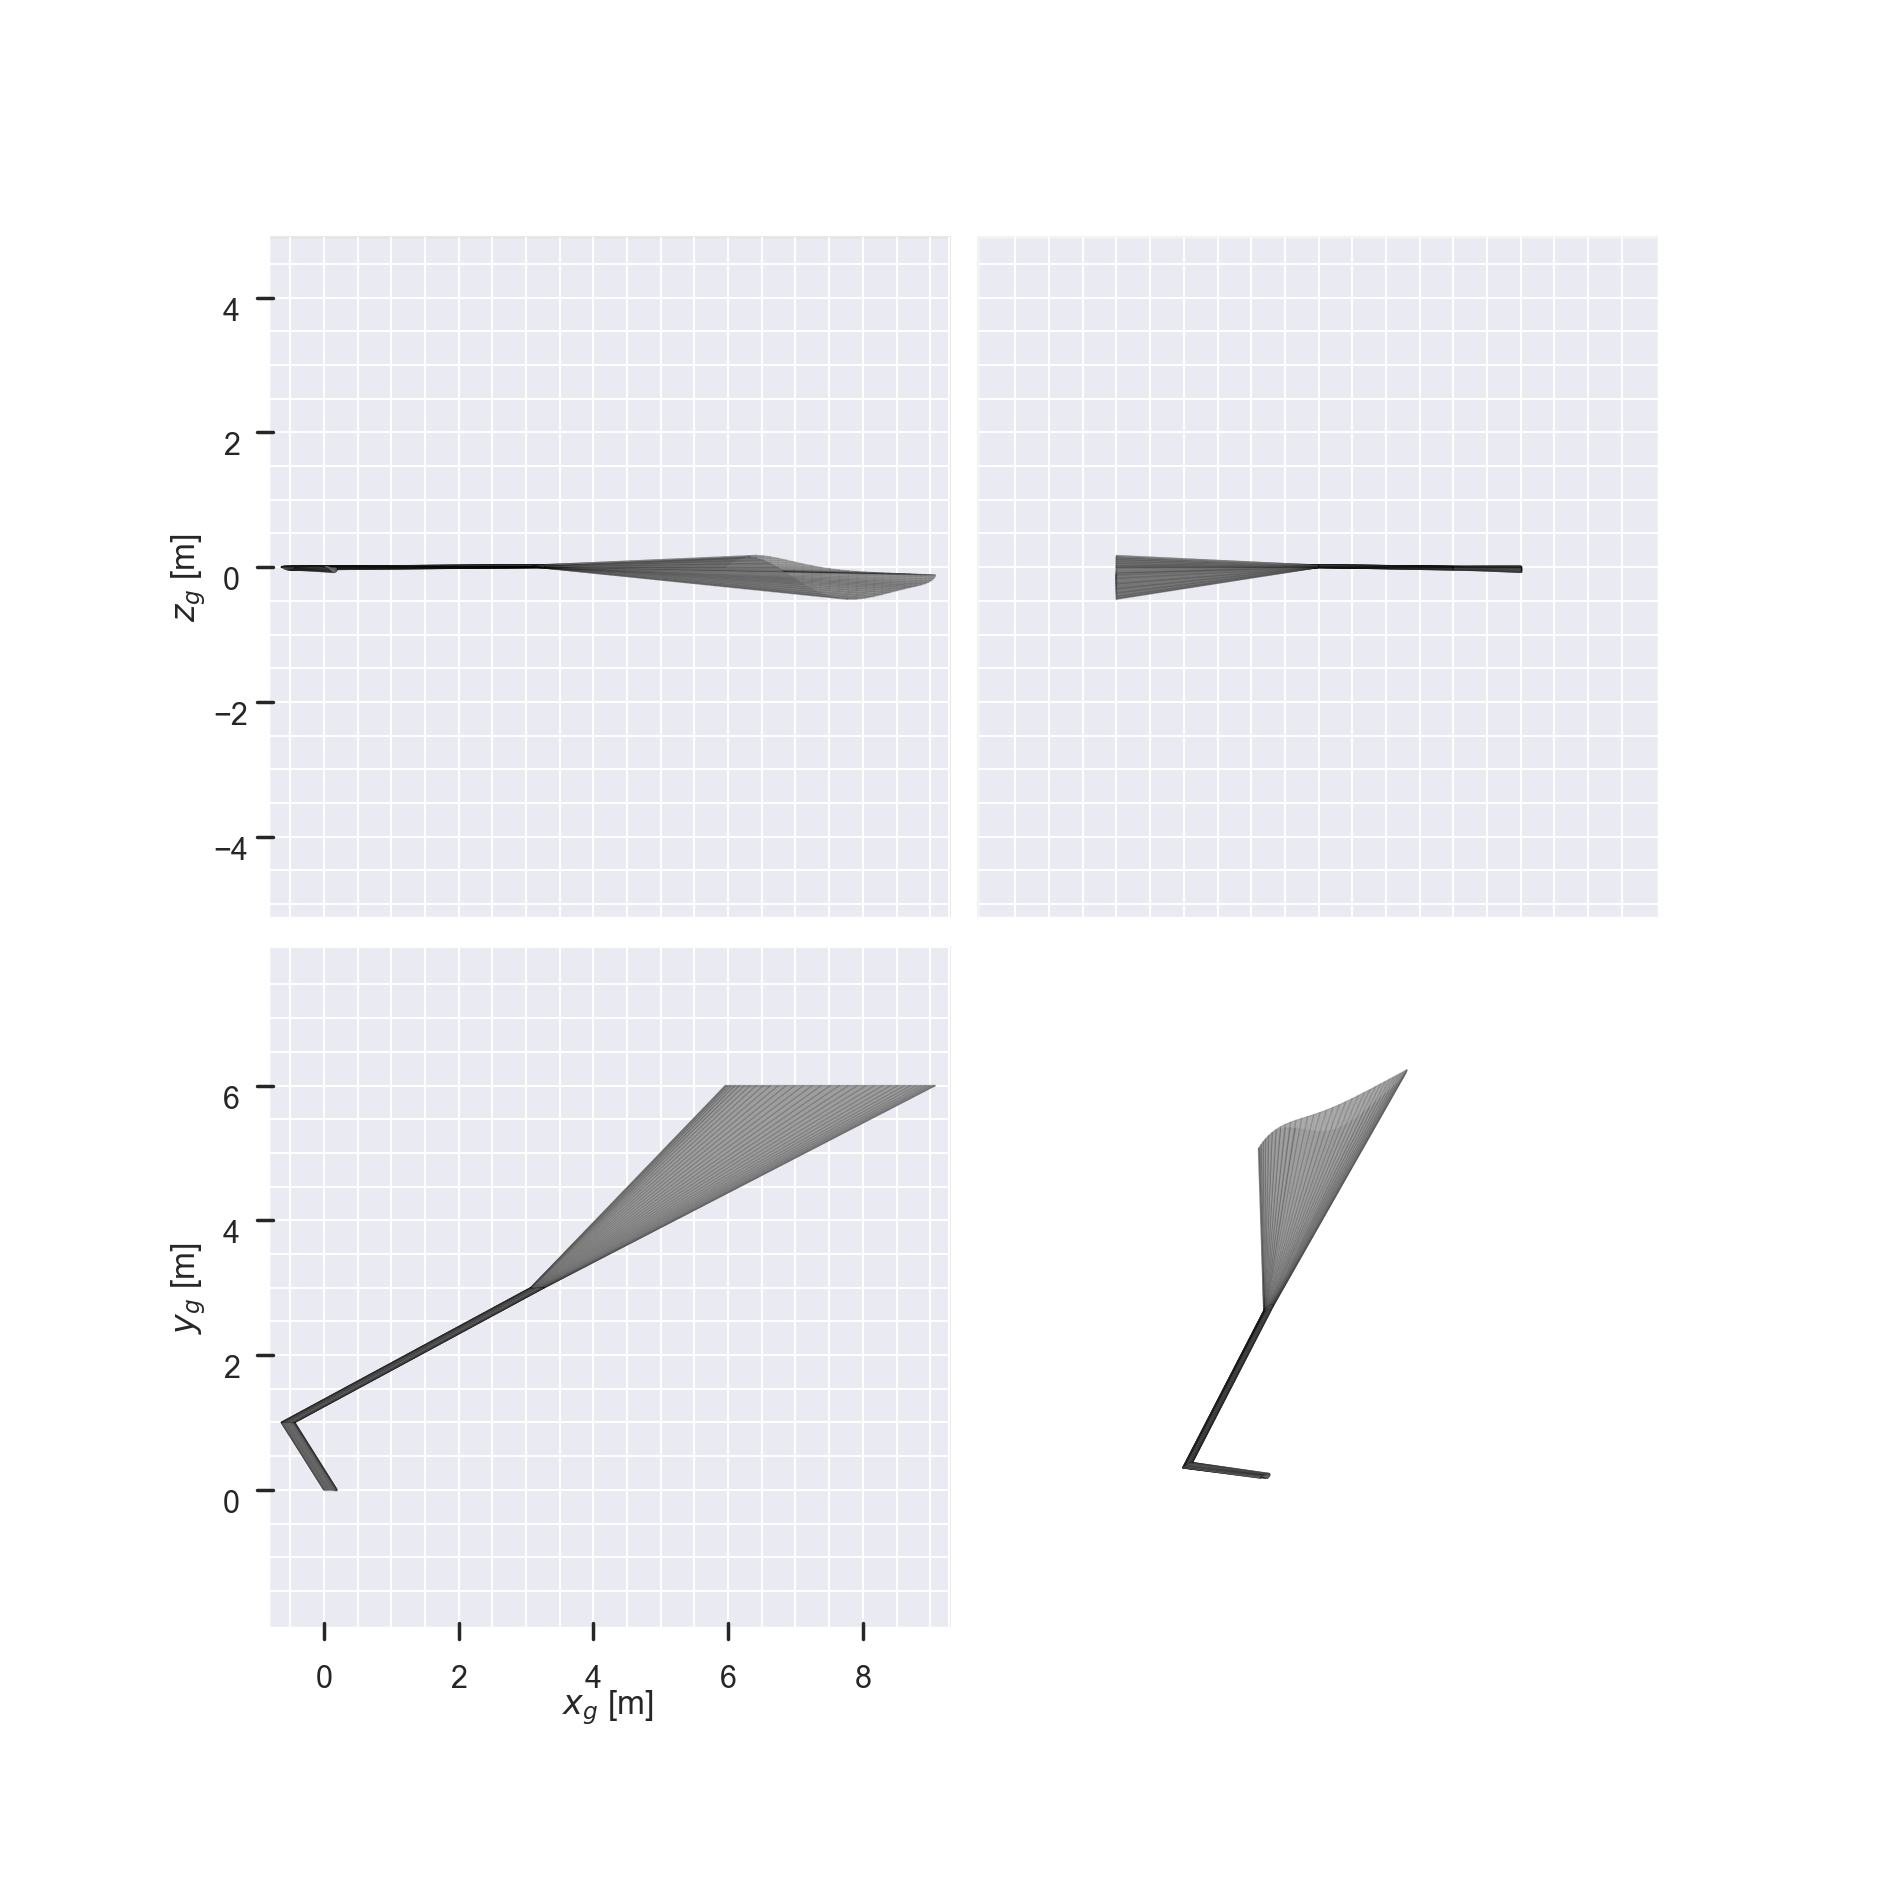

Reset was called!
Torque on Z: -183301489.73
Torque Penalty: 11.82
Lift: 57668014.275
Drag: 51512550.819
Lift/Drag: 1.119
Step: 1/5
Reward: -0.428
Reset was called!
Torque on Z: 16271641068.37
Torque Penalty: 14.61
Lift: 28294707673.083
Drag: 28363504233.546
Lift/Drag: 0.998
Step: 1/5
Reward: -50
0
Torque on Z: -234.35
Torque Penalty: 3.39
Lift: 587.499
Drag: 51.794
Lift/Drag: 11.343
Step: 2/5
Reward: 1.272
1
Torque on Z: -534.7
Torque Penalty: 3.9
Lift: 1117.295
Drag: 67.712
Lift/Drag: 16.501
Step: 3/5
Reward: 4.535
2
Torque on Z: -786.06
Torque Penalty: 4.14
Lift: 1290.013
Drag: 94.745
Lift/Drag: 13.616
Step: 4/5
Reward: 6.063
3
Torque on Z: -1082.12
Torque Penalty: 4.34
Lift: 2182.091
Drag: 228.139
Lift/Drag: 9.565
Step: 5/5
Reward: 5.224
4
Torque on Z: -448.18
Torque Penalty: 3.79
Lift: 1441.178
Drag: 87.376
Lift/Drag: 16.494
Step: 6/5
Reward: 18.289
===






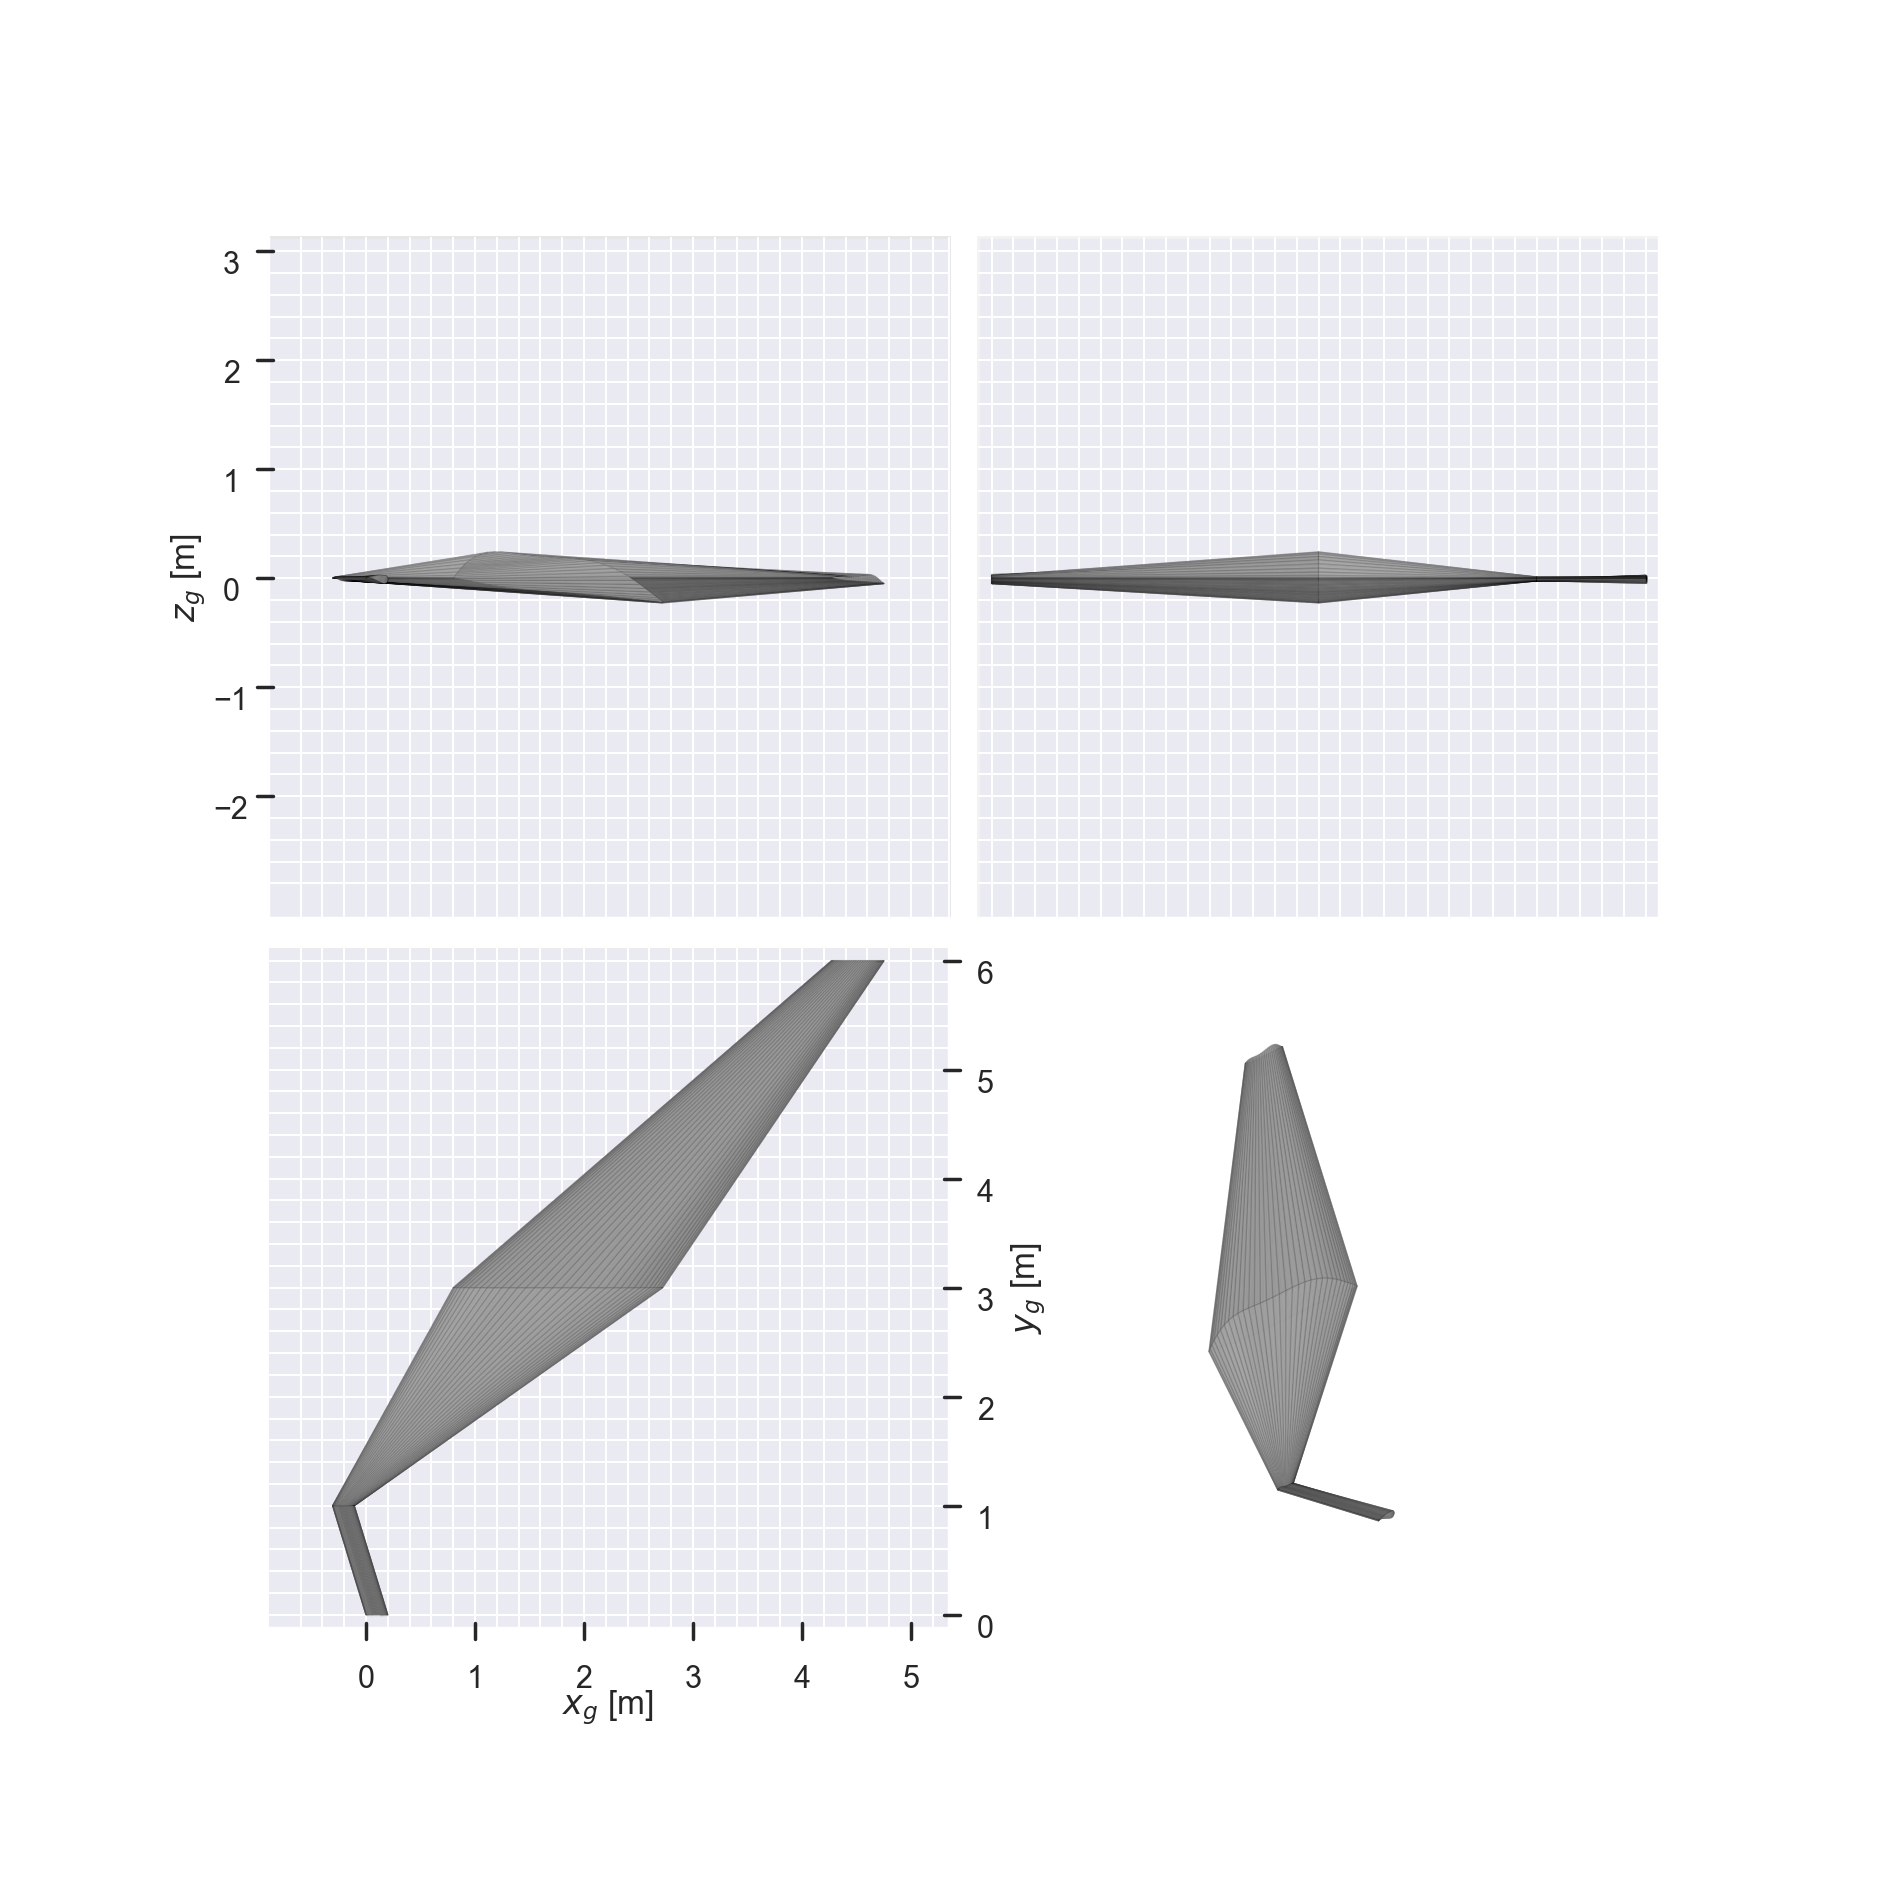

Reset was called!
Torque on Z: -49566284208.84
Torque Penalty: 15.3
Lift: 310447130.018
Drag: 7269456748.899
Lift/Drag: 0.043
Step: 1/5
Reward: -0.61
Reset was called!
Torque on Z: -29658.85
Torque Penalty: 6.4
Lift: -10162.328
Drag: 48819.226
Lift/Drag: -0.208
Step: 1/5
Reward: -1.056
0
Torque on Z: -174.01
Torque Penalty: 3.21
Lift: 339.782
Drag: 27.141
Lift/Drag: 12.519
Step: 2/5
Reward: 1.49
1
Torque on Z: -240.07
Torque Penalty: 3.41
Lift: 653.392
Drag: 24.132
Lift/Drag: 27.076
Step: 3/5
Reward: 8.521
2
Torque on Z: -304.73
Torque Penalty: 3.55
Lift: 664.726
Drag: 35.942
Lift/Drag: 18.495
Step: 4/5
Reward: 9.562
3
Torque on Z: -219.0
Torque Penalty: 3.35
Lift: 460.098
Drag: 18.868
Lift/Drag: 24.385
Step: 5/5
Reward: 21.037
4
Torque on Z: -291.26
Torque Penalty: 3.53
Lift: 894.194
Drag: 50.388
Lift/Drag: 17.746
Step: 6/5
Reward: 20.478
===






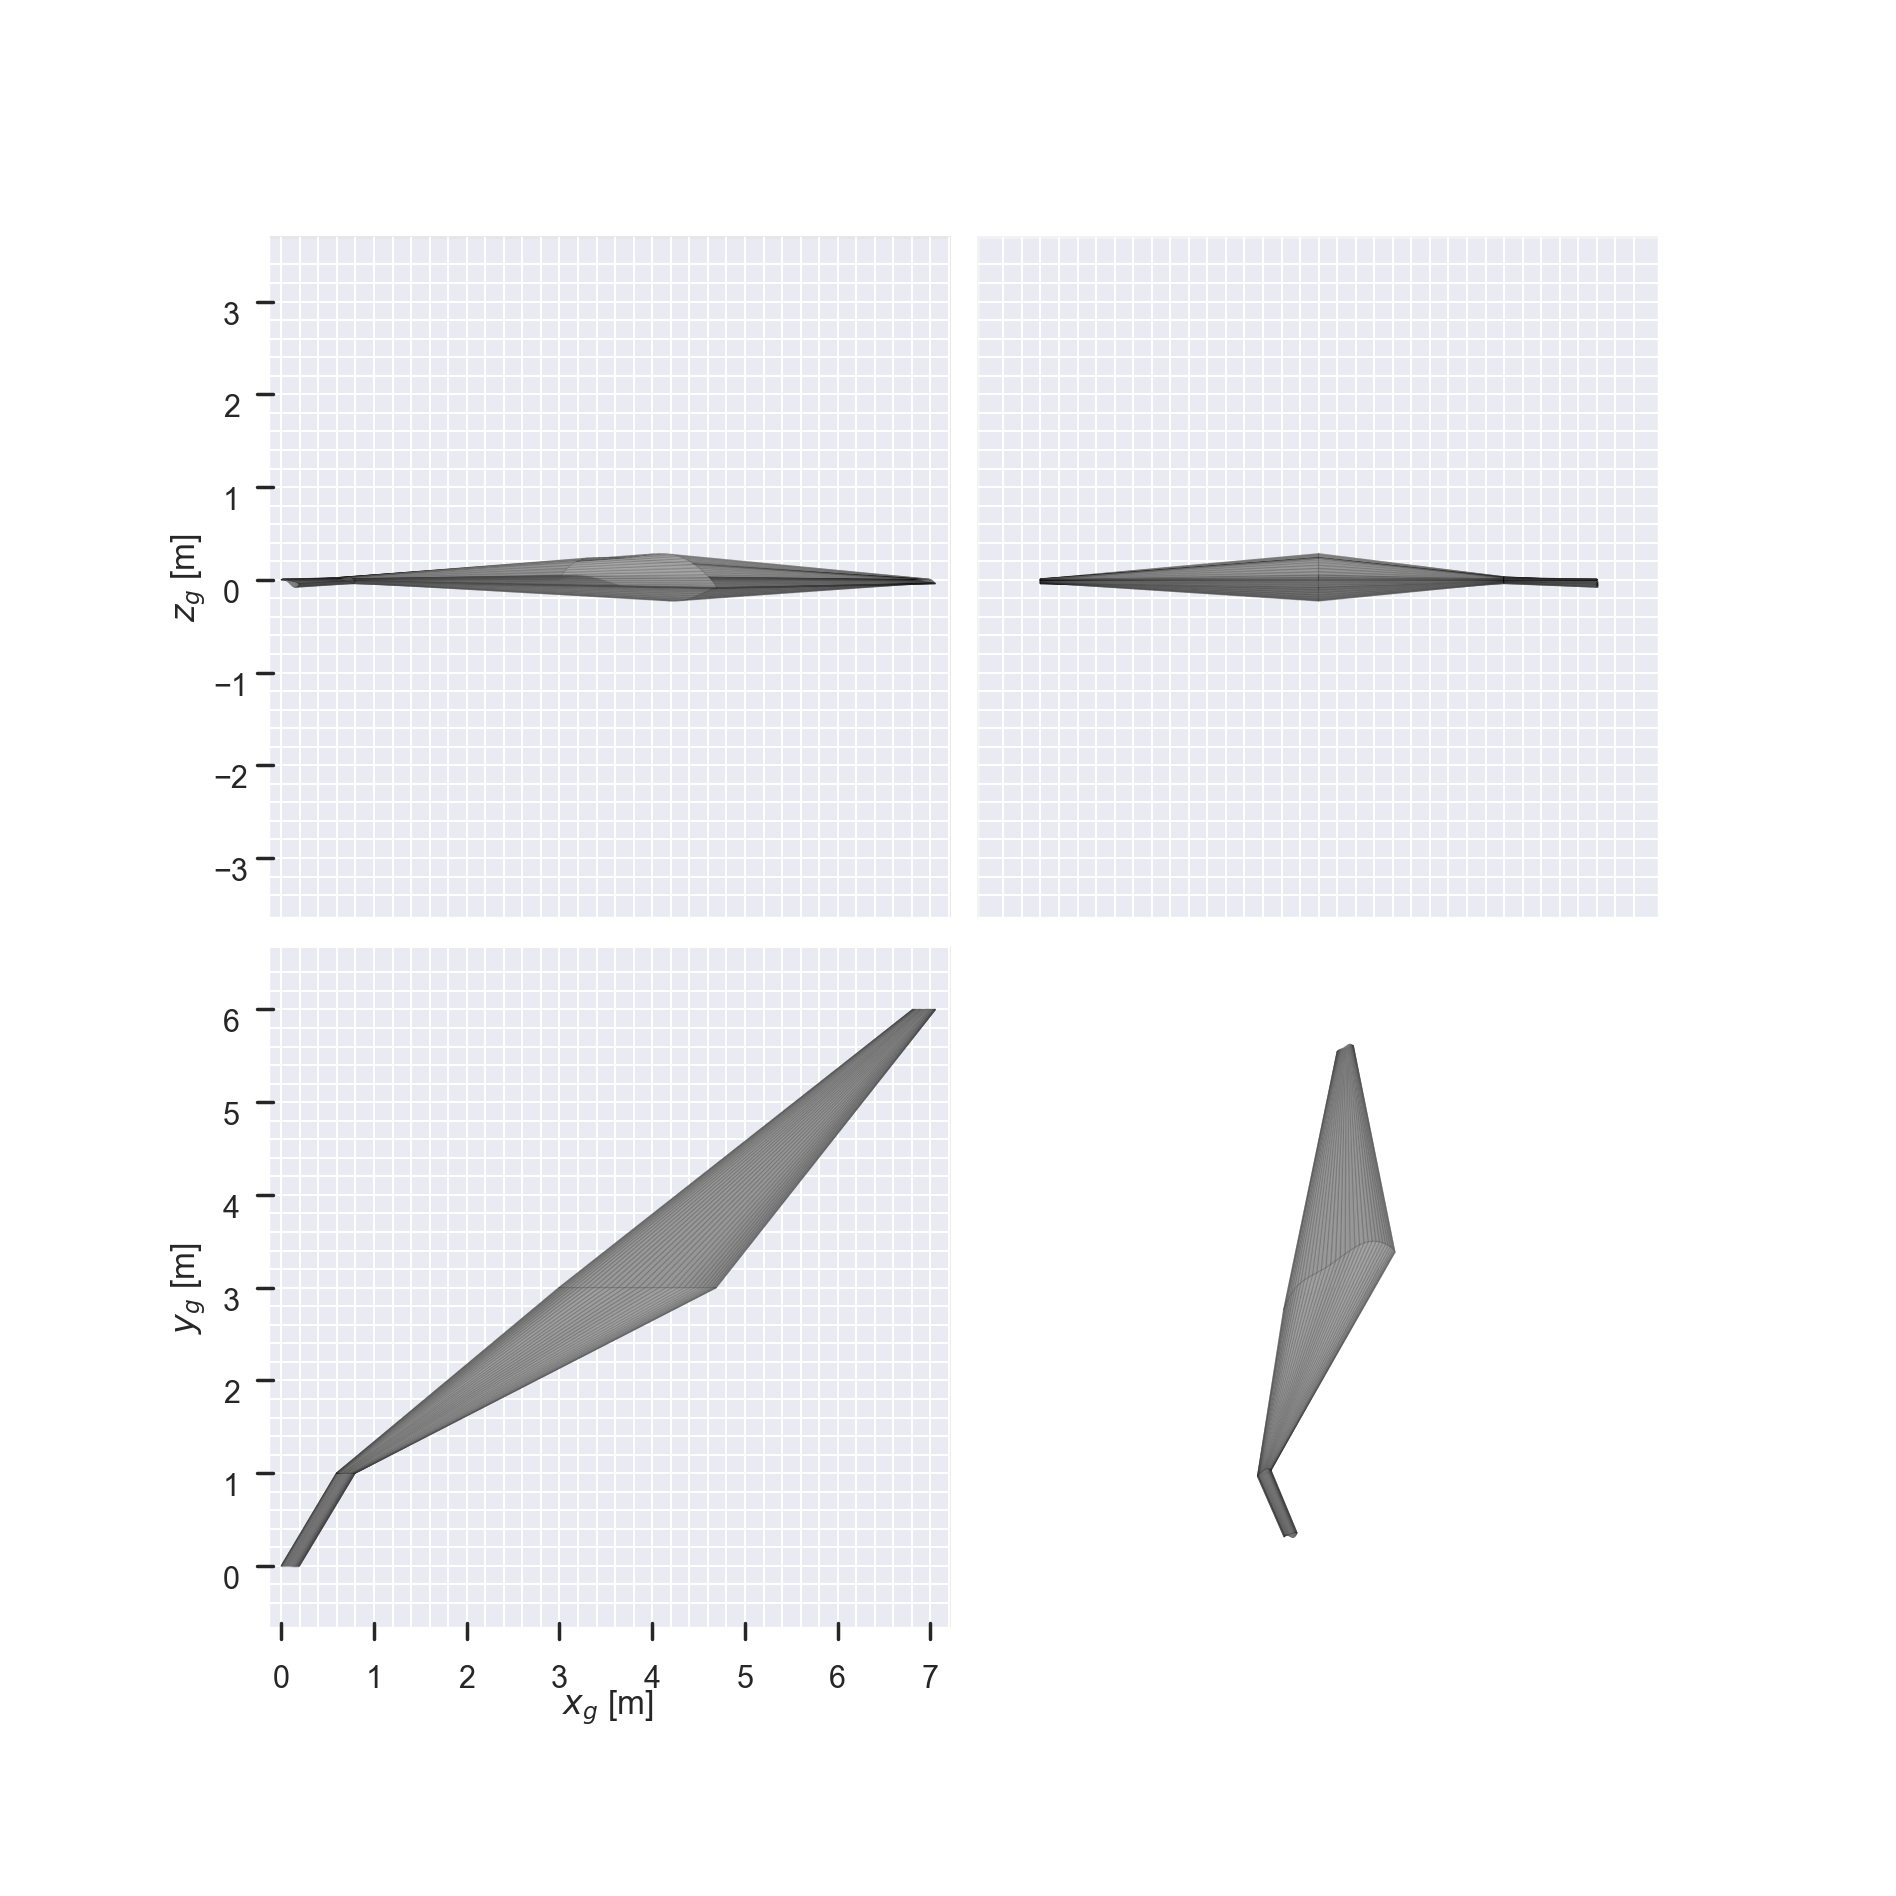

Reset was called!
Torque on Z: 16938008687.74
Torque Penalty: 14.63
Lift: 665100784.463
Drag: 19730053572.487
Lift/Drag: 0.034
Step: 1/5
Reward: -50
Reset was called!
Torque on Z: 211619219638.48
Torque Penalty: 16.2
Lift: -237875593591.596
Drag: 111160119941.648
Lift/Drag: -2.14
Step: 1/5
Reward: -50
0
Torque on Z: -8.44
Torque Penalty: 1.32
Lift: 17.474
Drag: 2.65
Lift/Drag: 6.593
Step: 2/5
Reward: 0.843
1
Torque on Z: -96.66
Torque Penalty: 2.84
Lift: -165.523
Drag: 24.063
Lift/Drag: -6.879
Step: 3/5
Reward: -8.222
2
Torque on Z: -11.98
Torque Penalty: 1.54
Lift: 73.385
Drag: 2.342
Lift/Drag: 31.328
Step: 4/5
Reward: 19.062
3
Torque on Z: -49.04
Torque Penalty: 2.42
Lift: 254.302
Drag: 8.894
Lift/Drag: 28.593
Step: 5/5
Reward: 26.174
4
Torque on Z: -17.37
Torque Penalty: 1.77
Lift: 126.402
Drag: 1.926
Lift/Drag: 65.634
Step: 6/5
Reward: 91.958
===






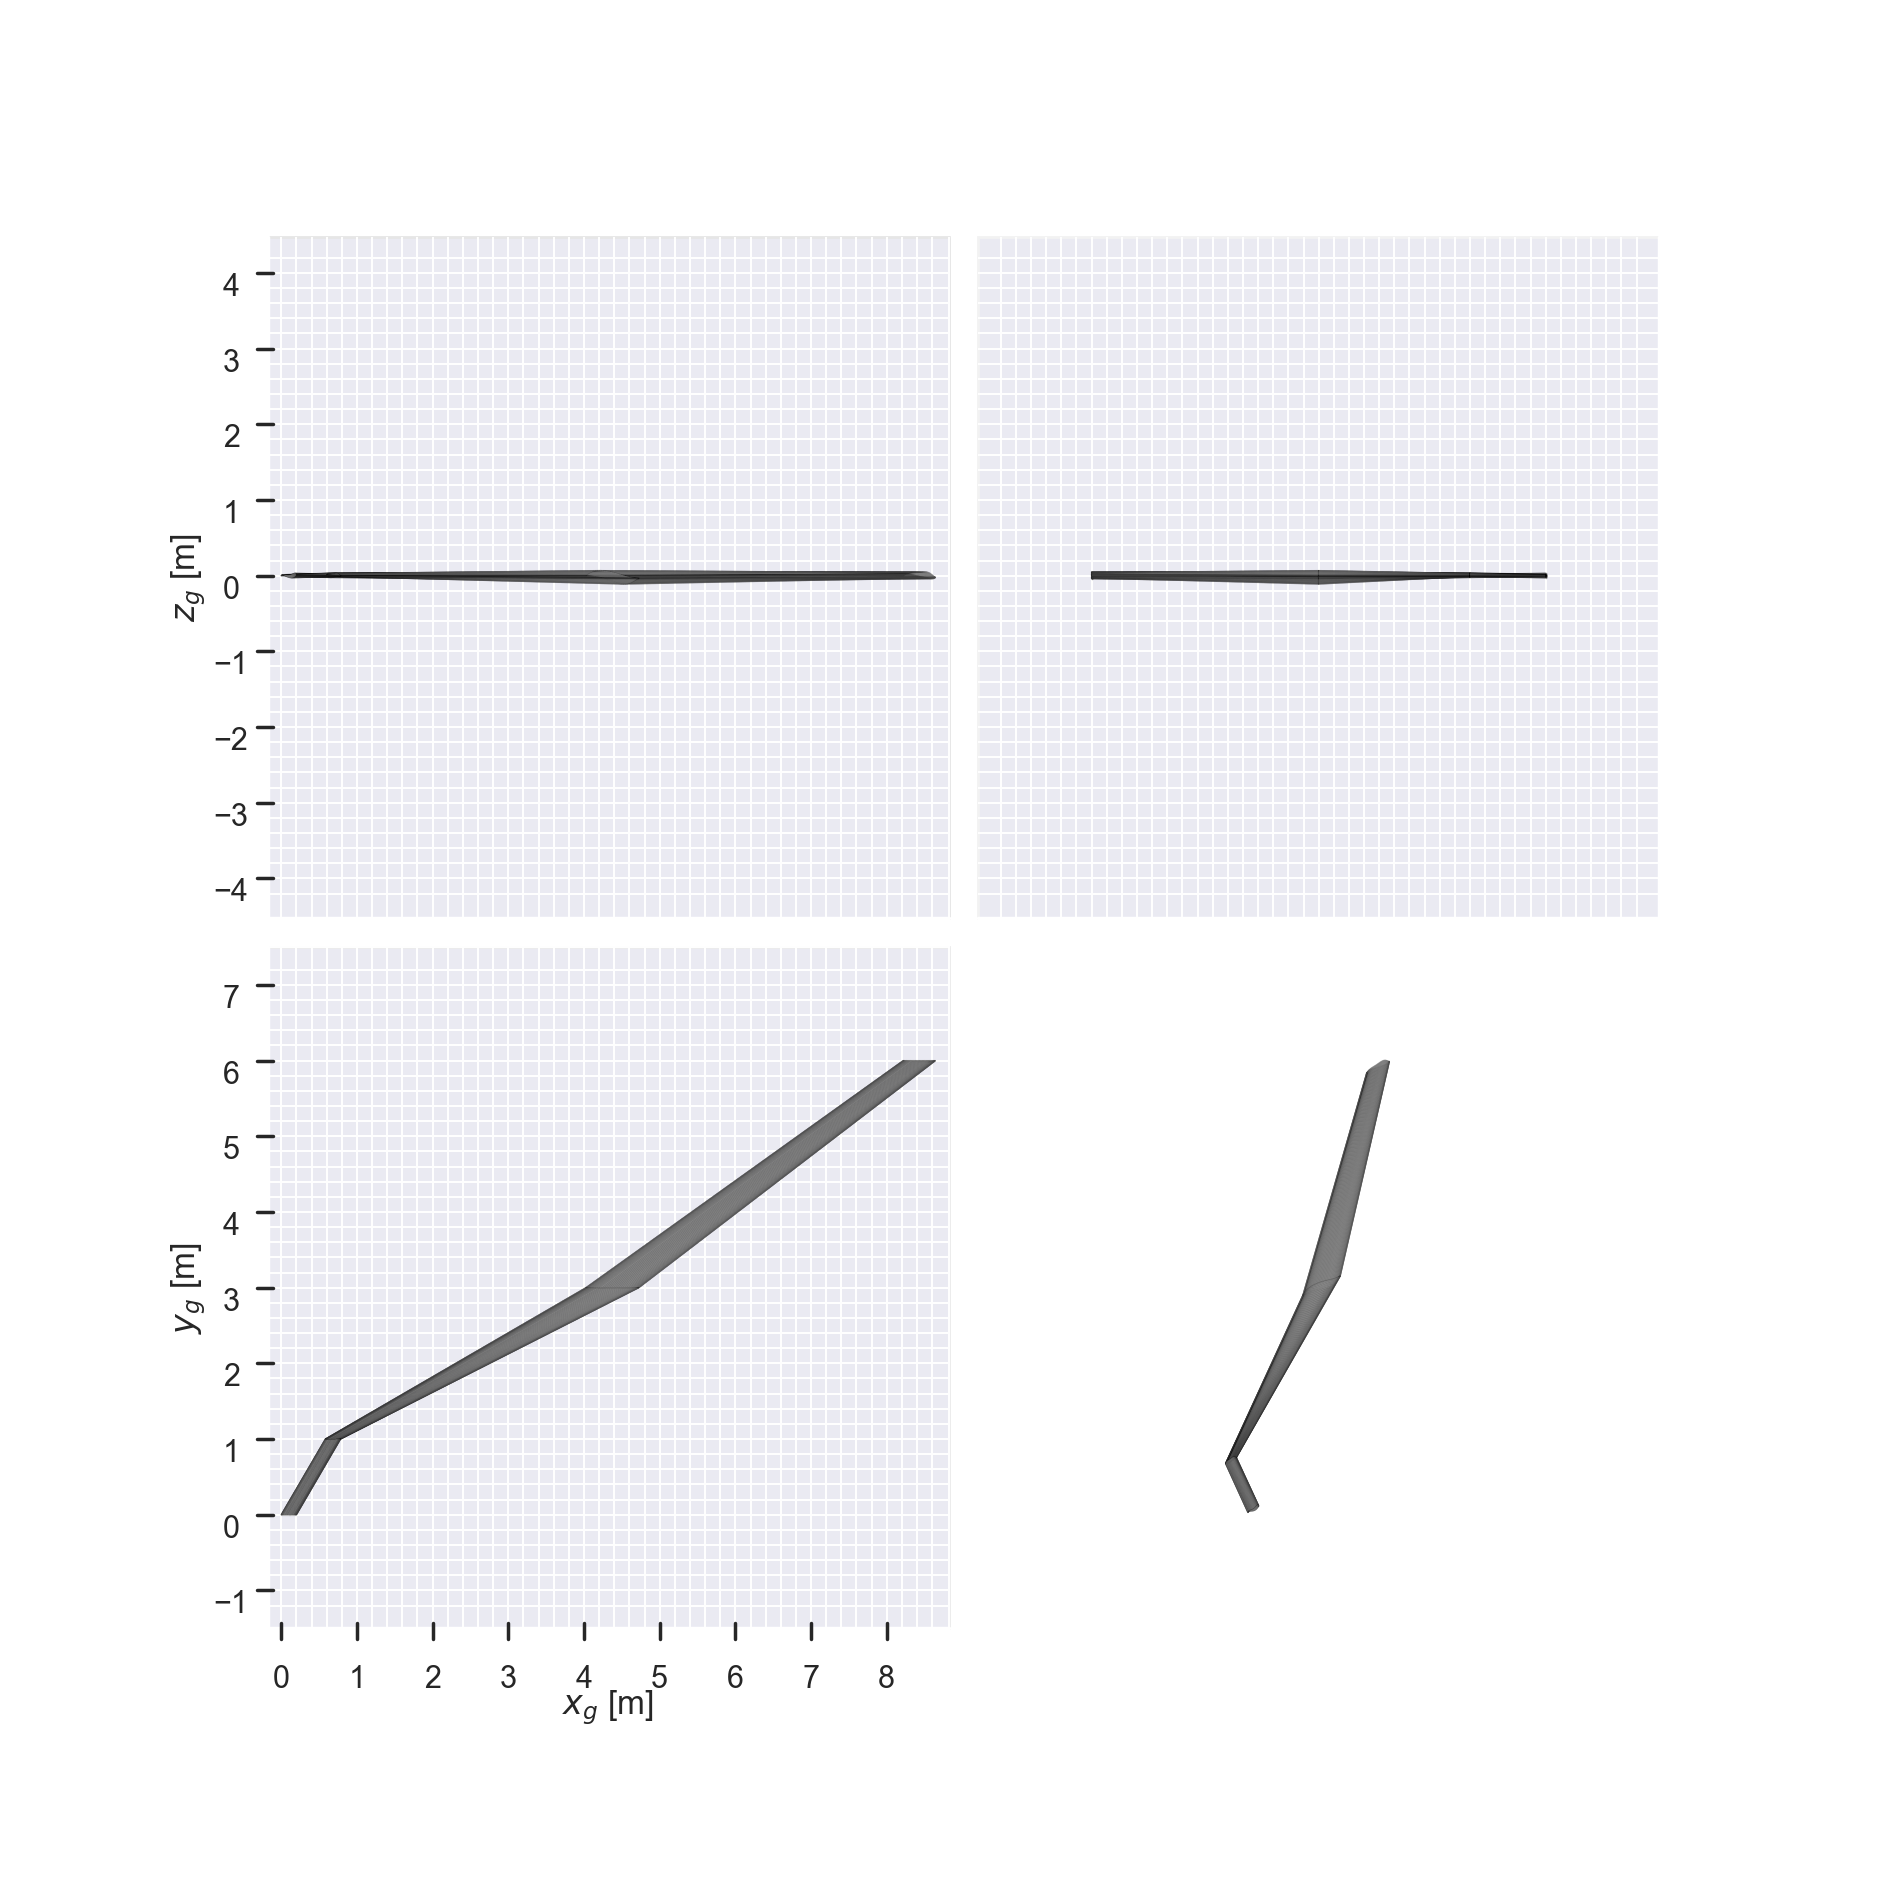

Reset was called!
Torque on Z: -50350.18
Torque Penalty: 6.73
Lift: 2897.482
Drag: 47481.591
Lift/Drag: 0.061
Step: 1/5
Reward: -0.267
Reset was called!
Torque on Z: -23766820.49
Torque Penalty: 10.55
Lift: 230878.583
Drag: 106840794.473
Lift/Drag: 0.002
Step: 1/5
Reward: -0.422
0
Torque on Z: -34.38
Torque Penalty: 2.2
Lift: 403.14
Drag: 14.817
Lift/Drag: 27.207
Step: 2/5
Reward: 4.001
1
Torque on Z: -134.24
Torque Penalty: 3.04
Lift: 327.556
Drag: 7.794
Lift/Drag: 42.029
Step: 3/5
Reward: 14.035
2
Torque on Z: -191.46
Torque Penalty: 3.26
Lift: 857.637
Drag: 36.843
Lift/Drag: 23.278
Step: 4/5
Reward: 12.809
3
Torque on Z: -140.42
Torque Penalty: 3.07
Lift: 517.584
Drag: 13.963
Lift/Drag: 37.067
Step: 5/5
Reward: 33.995
4
Torque on Z: -840.3
Torque Penalty: 4.18
Lift: 862.325
Drag: 76.672
Lift/Drag: 11.247
Step: 6/5
Reward: 10.171
===






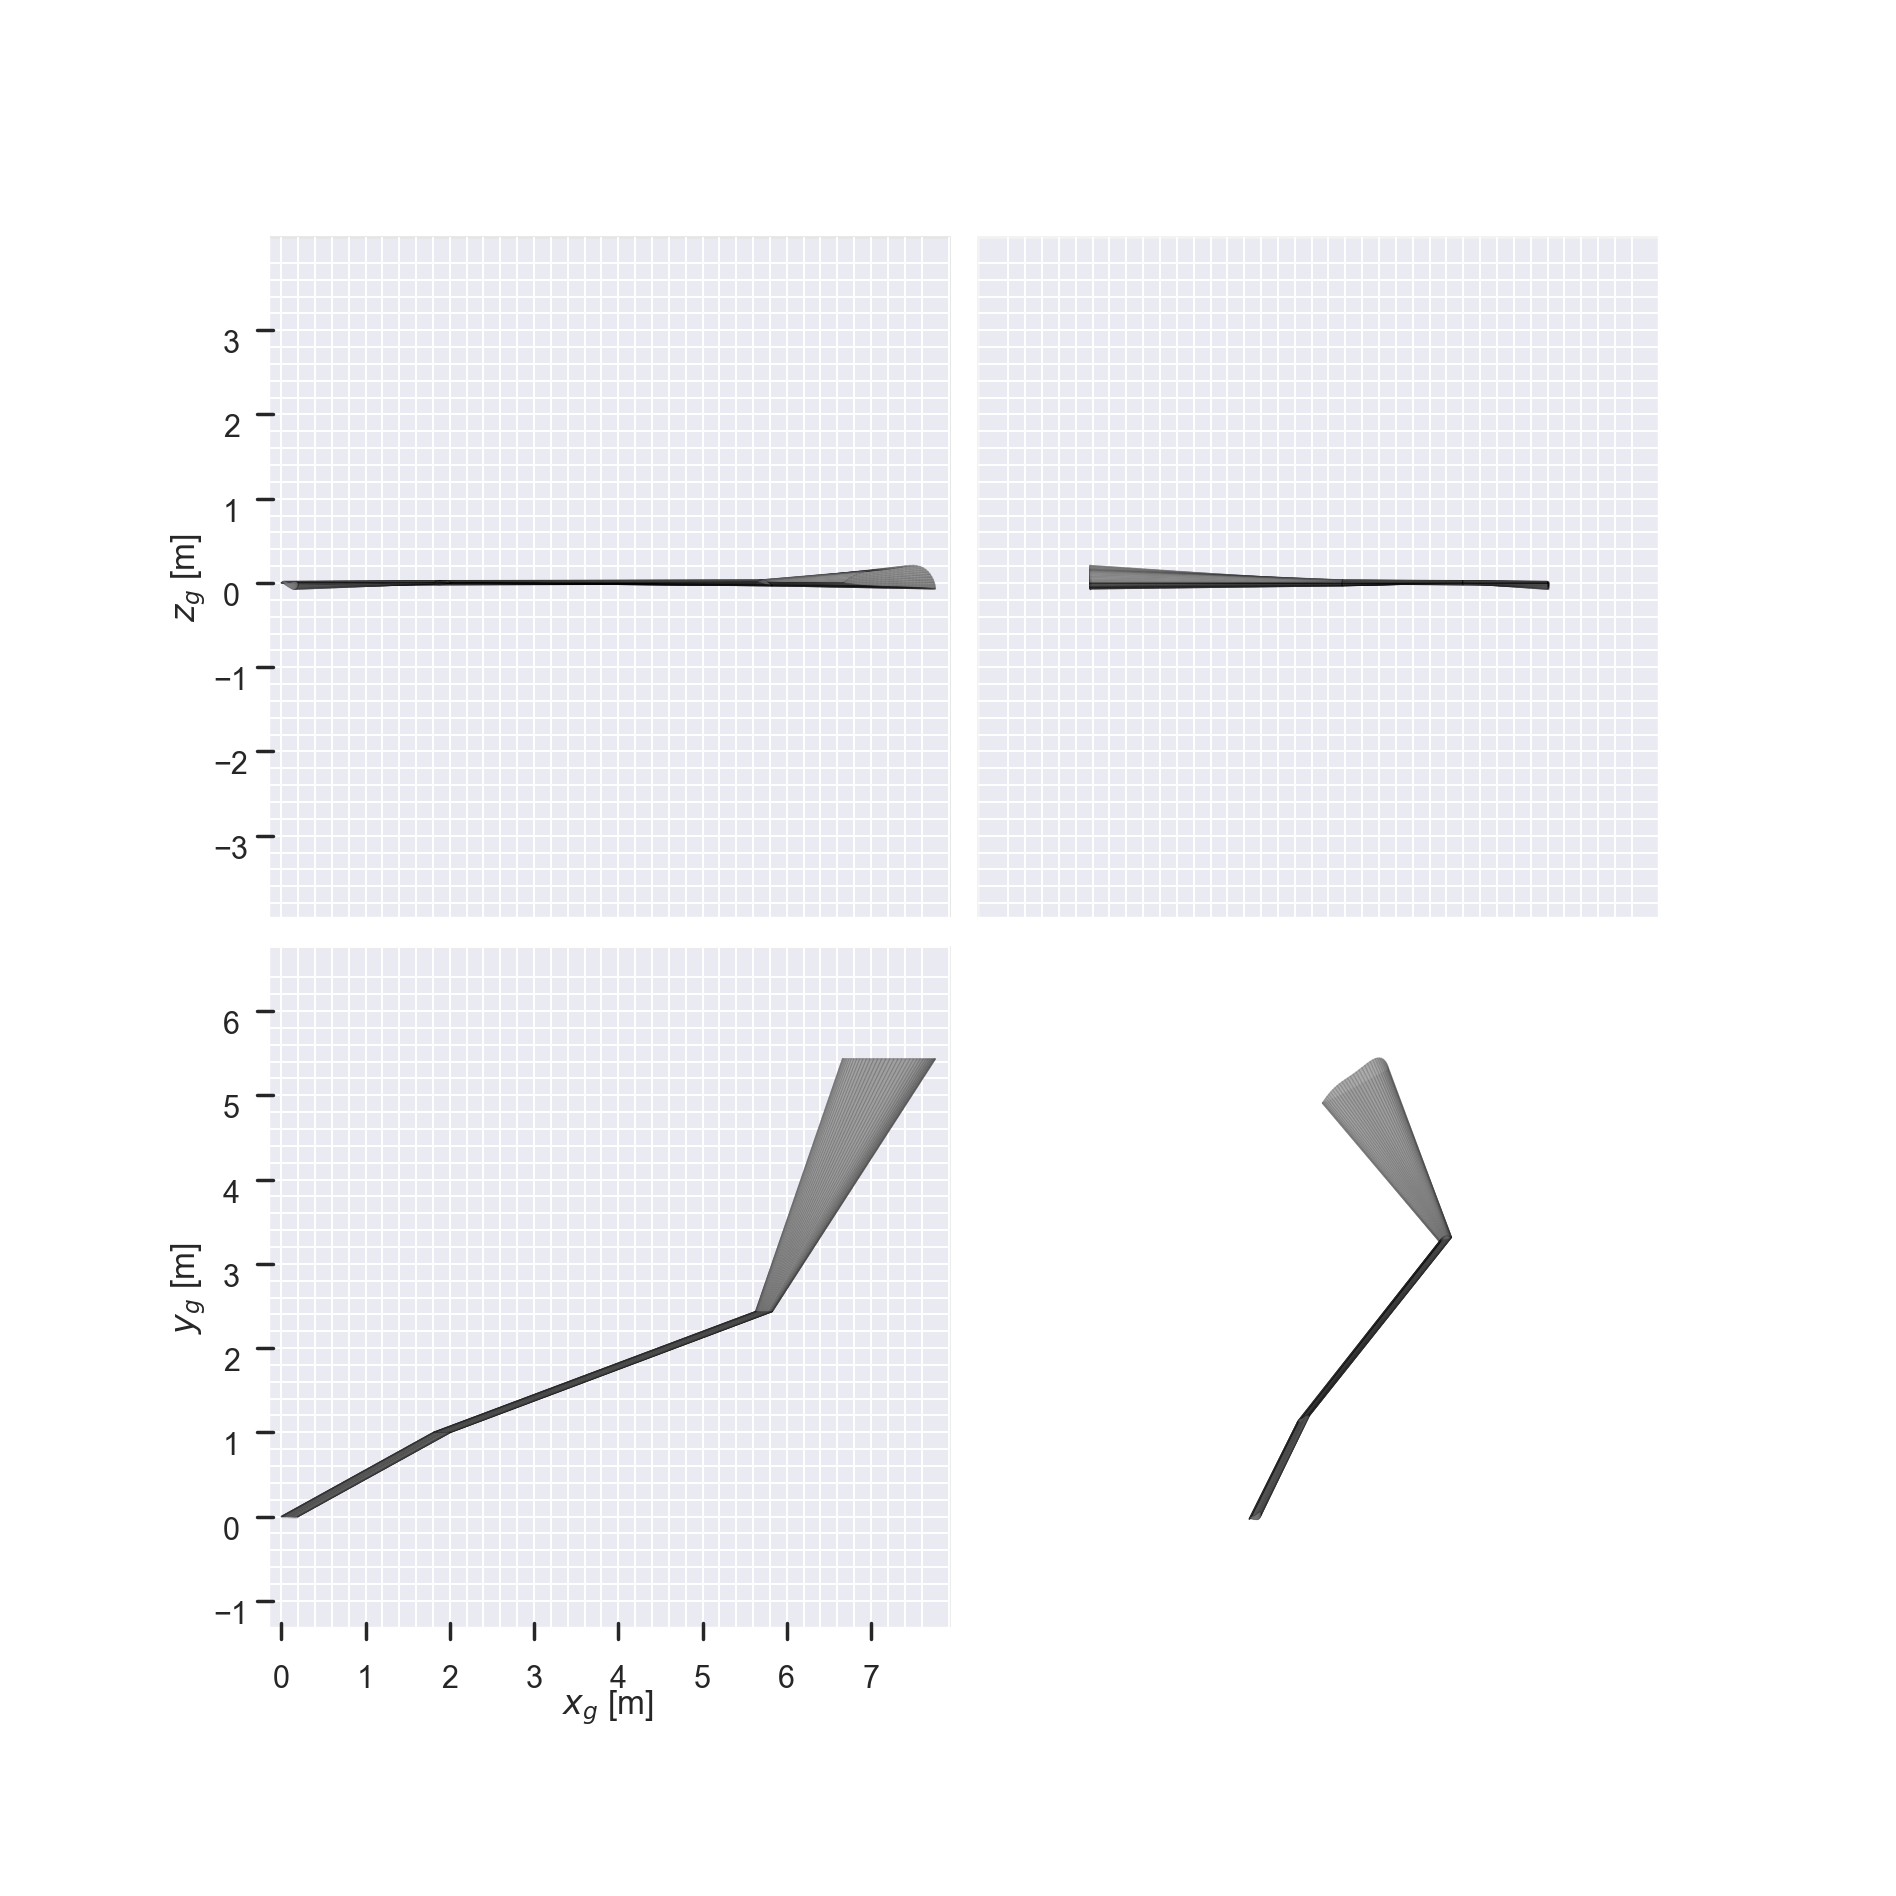

Reset was called!
Torque on Z: -24751240300.99
Torque Penalty: 14.87
Lift: -1674329463.818
Drag: 3059774266.841
Lift/Drag: -0.547
Step: 1/5
Reward: -1.395
Reset was called!
Torque on Z: -1782053.81
Torque Penalty: 8.94
Lift: -281618.15
Drag: 332624.683
Lift/Drag: -0.847
Step: 1/5
Reward: -1.158
0
Torque on Z: -477.49
Torque Penalty: 3.83
Lift: 462.525
Drag: 75.408
Lift/Drag: 6.134
Step: 2/5
Reward: 0.368
1
Torque on Z: -72.57
Torque Penalty: 2.66
Lift: 257.708
Drag: 5.092
Lift/Drag: 50.606
Step: 3/5
Reward: 17.26
2
Torque on Z: -20.25
Torque Penalty: 1.87
Lift: 172.903
Drag: 3.006
Lift/Drag: 57.517
Step: 4/5
Reward: 35.614
3
Torque on Z: -21.57
Torque Penalty: 1.91
Lift: 354.397
Drag: 9.778
Lift/Drag: 36.244
Step: 5/5
Reward: 34.335
4
Torque on Z: -5.57
Torque Penalty: 1.07
Lift: 280.482
Drag: 3.228
Lift/Drag: 86.892
Step: 6/5
Reward: 123.589
===






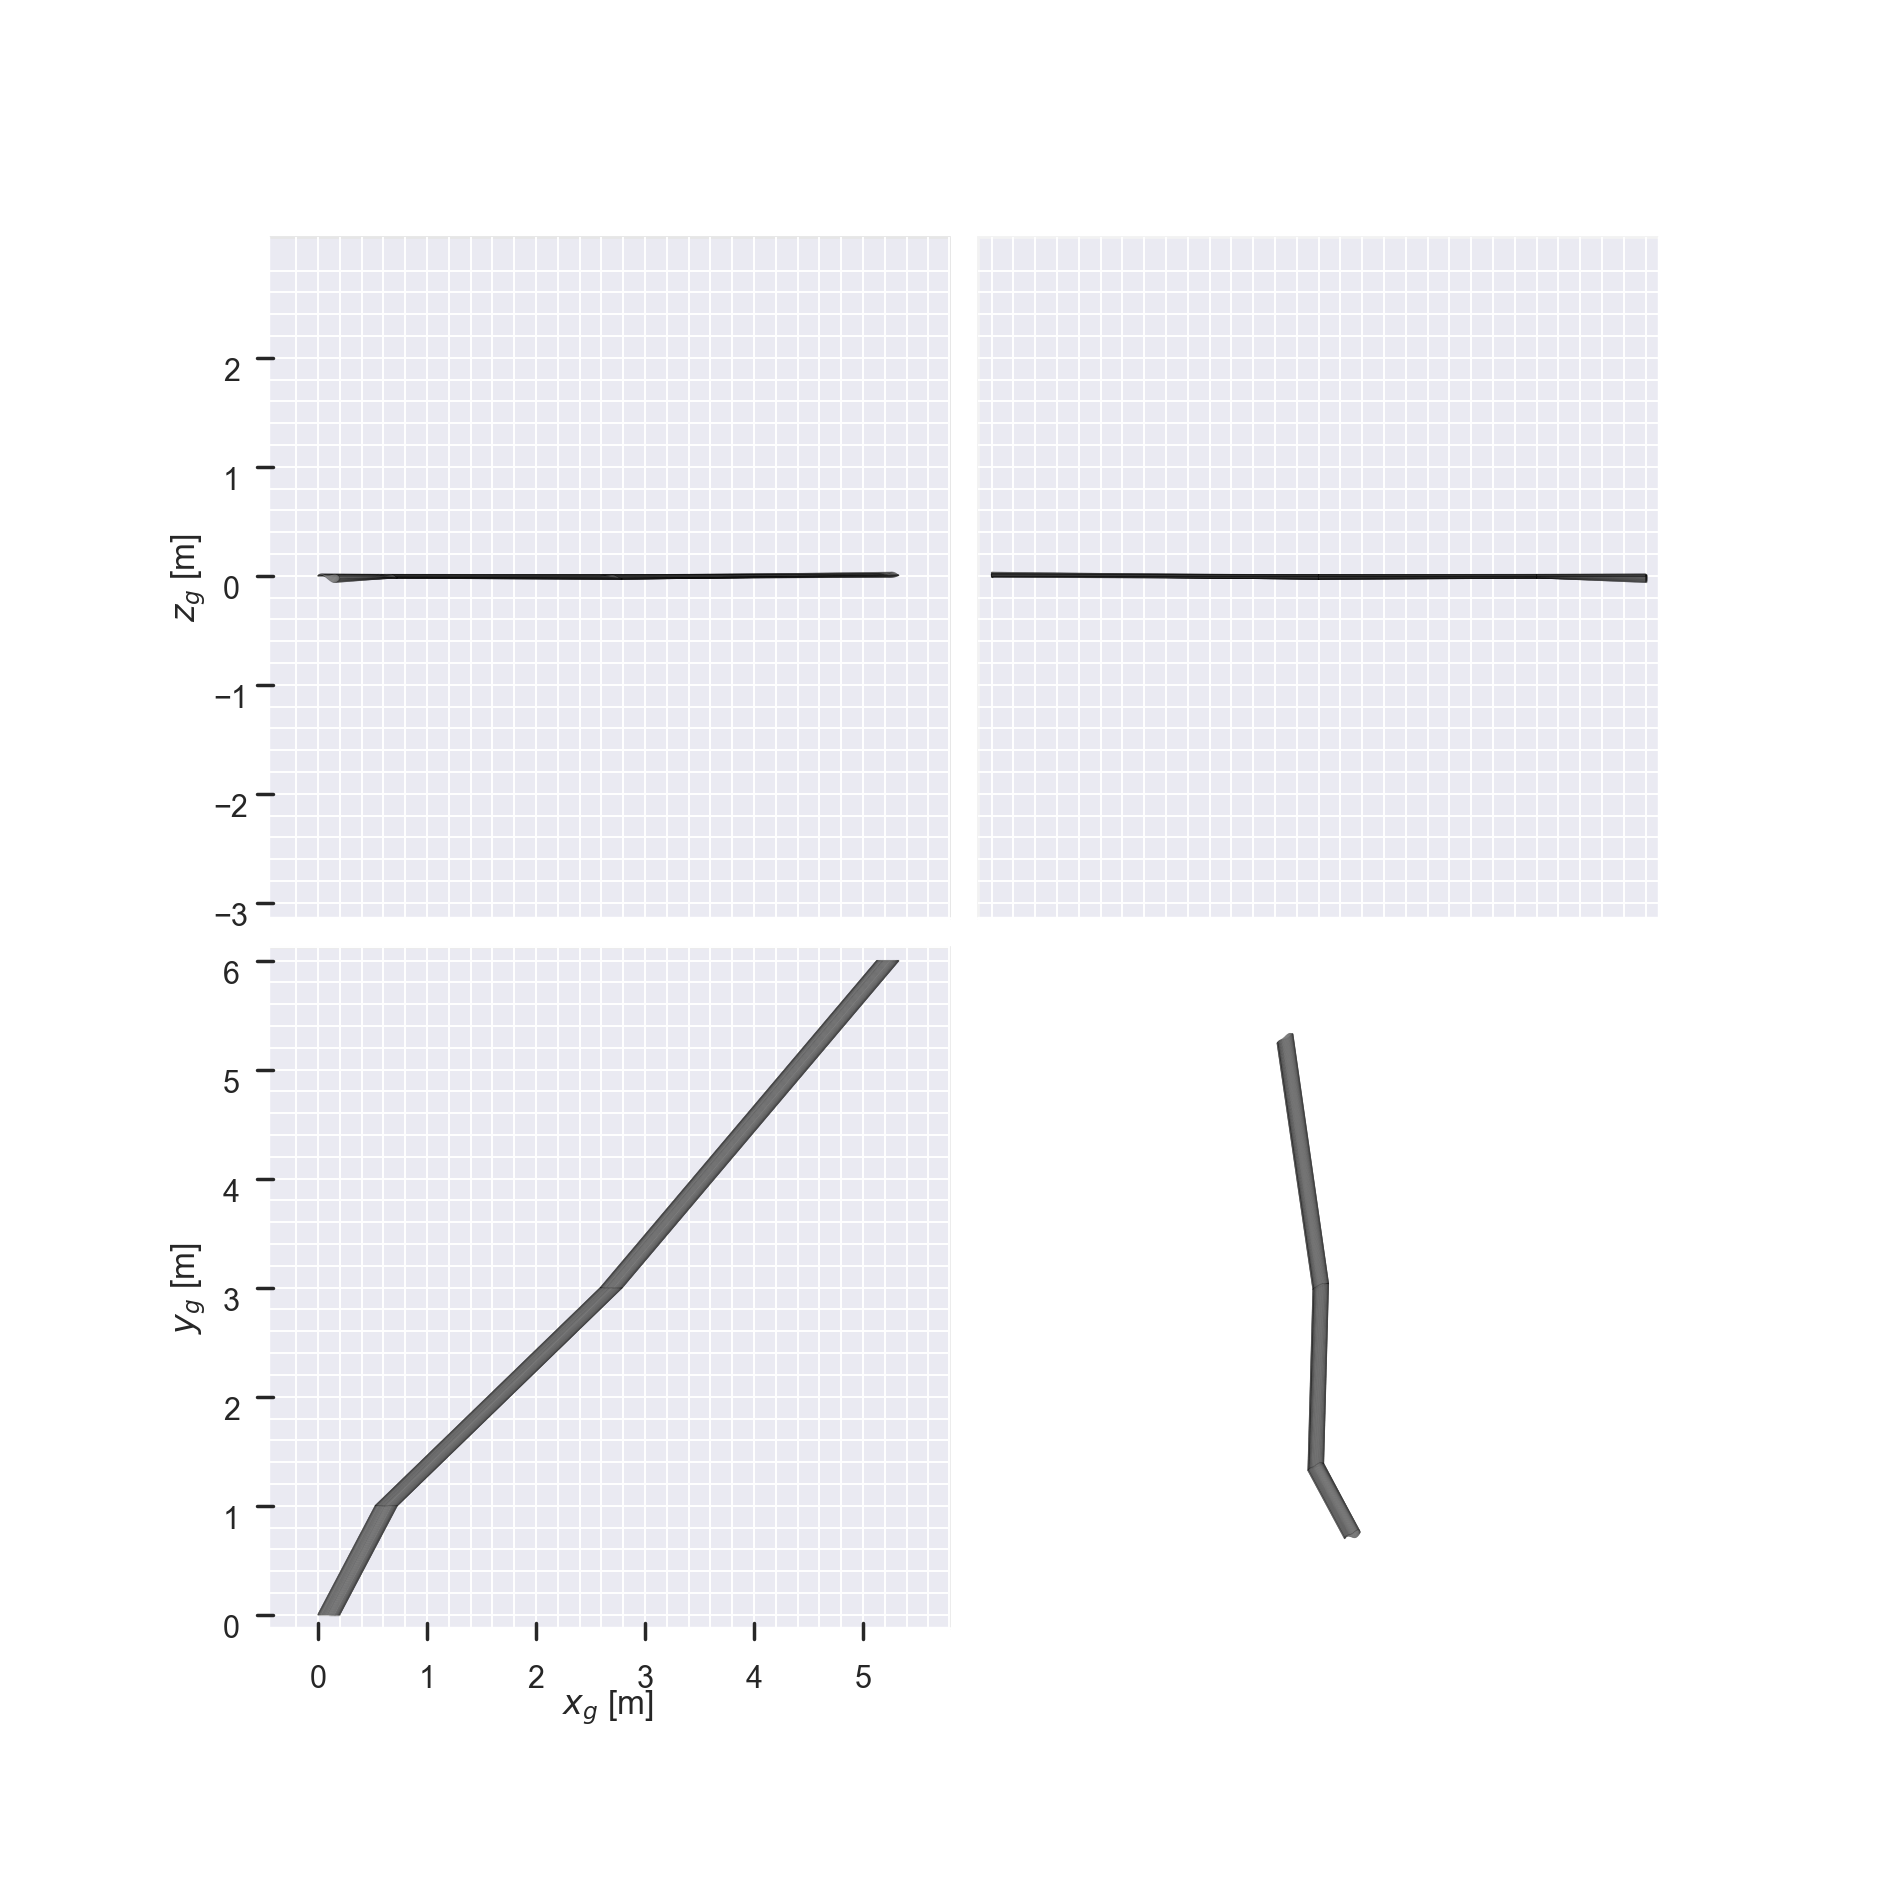

Reset was called!
Torque on Z: -242993555.49
Torque Penalty: 12.0
Lift: 19204154.85
Drag: 33885089.304
Lift/Drag: 0.567
Step: 1/5
Reward: -0.457
Reset was called!
Torque on Z: 117332885175.7
Torque Penalty: 15.84
Lift: 68282062923.596
Drag: 397291062396.185
Lift/Drag: 0.172
Step: 1/5
Reward: -50
0
Torque on Z: -52.69
Torque Penalty: 2.46
Lift: 129.205
Drag: 17.975
Lift/Drag: 7.188
Step: 2/5
Reward: 0.756
1
Torque on Z: -332.11
Torque Penalty: 3.61
Lift: 867.886
Drag: 53.972
Lift/Drag: 16.08
Step: 3/5
Reward: 4.49
2
Torque on Z: -71.25
Torque Penalty: 2.65
Lift: 385.559
Drag: 7.229
Lift/Drag: 53.334
Step: 4/5
Reward: 32.437
3
Torque on Z: -35.18
Torque Penalty: 2.21
Lift: 468.654
Drag: 9.012
Lift/Drag: 52.005
Step: 5/5
Reward: 49.793
4
Torque on Z: -271.24
Torque Penalty: 3.48
Lift: 1031.245
Drag: 59.149
Lift/Drag: 17.435
Step: 6/5
Reward: 20.093
===






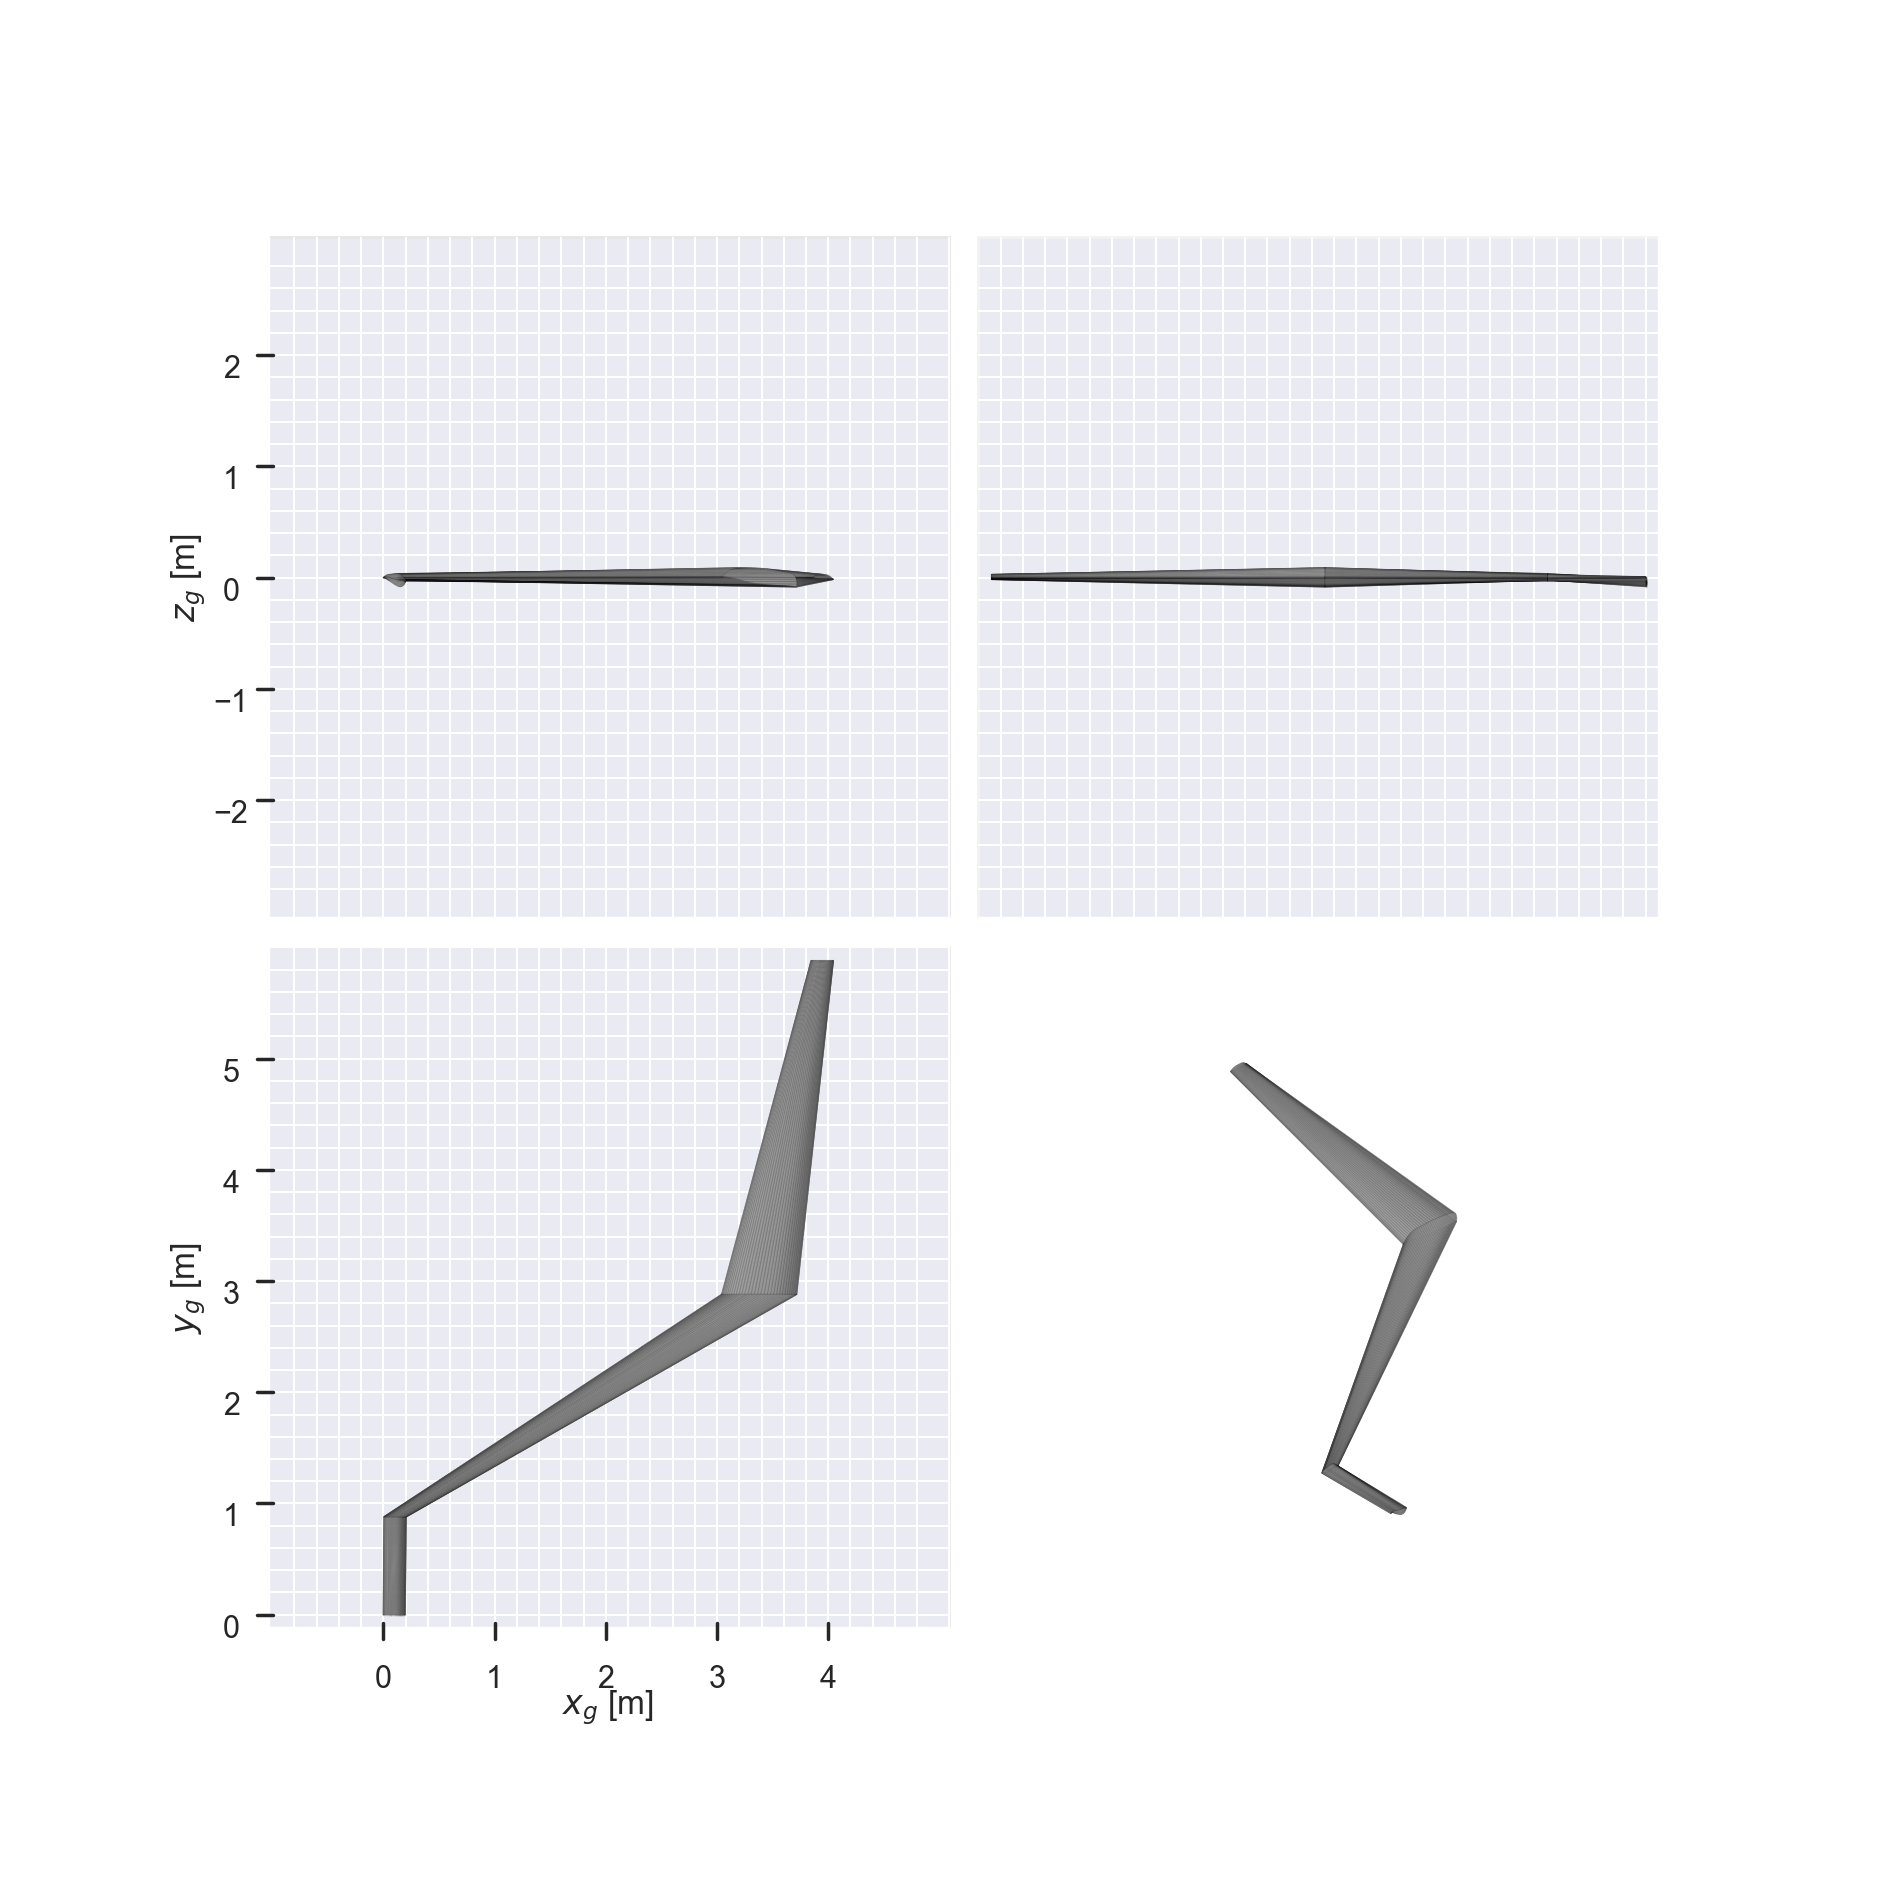

Reset was called!
Torque on Z: -5467388.48
Torque Penalty: 9.64
Lift: 2147844.842
Drag: 18423045.688
Lift/Drag: 0.117
Step: 1/5
Reward: -0.381
Reset was called!
Torque on Z: -167877.96
Torque Penalty: 7.48
Lift: -2263.277
Drag: 12837.265
Lift/Drag: -0.176
Step: 1/5
Reward: -1.099
0
Torque on Z: -309.85
Torque Penalty: 3.56
Lift: 429.117
Drag: 48.299
Lift/Drag: 8.885
Step: 2/5
Reward: 0.851
1
Torque on Z: -306.54
Torque Penalty: 3.56
Lift: 484.918
Drag: 17.646
Lift/Drag: 27.48
Step: 3/5
Reward: 8.612
2
Torque on Z: -386.41
Torque Penalty: 3.7
Lift: 789.034
Drag: 32.717
Lift/Drag: 24.117
Step: 4/5
Reward: 13.066
3
Torque on Z: -491.68
Torque Penalty: 3.85
Lift: 927.137
Drag: 58.308
Lift/Drag: 15.901
Step: 5/5
Reward: 12.05
4
Torque on Z: -1153.39
Torque Penalty: 4.38
Lift: 1225.137
Drag: 75.235
Lift/Drag: 16.284
Step: 6/5
Reward: 17.141
===






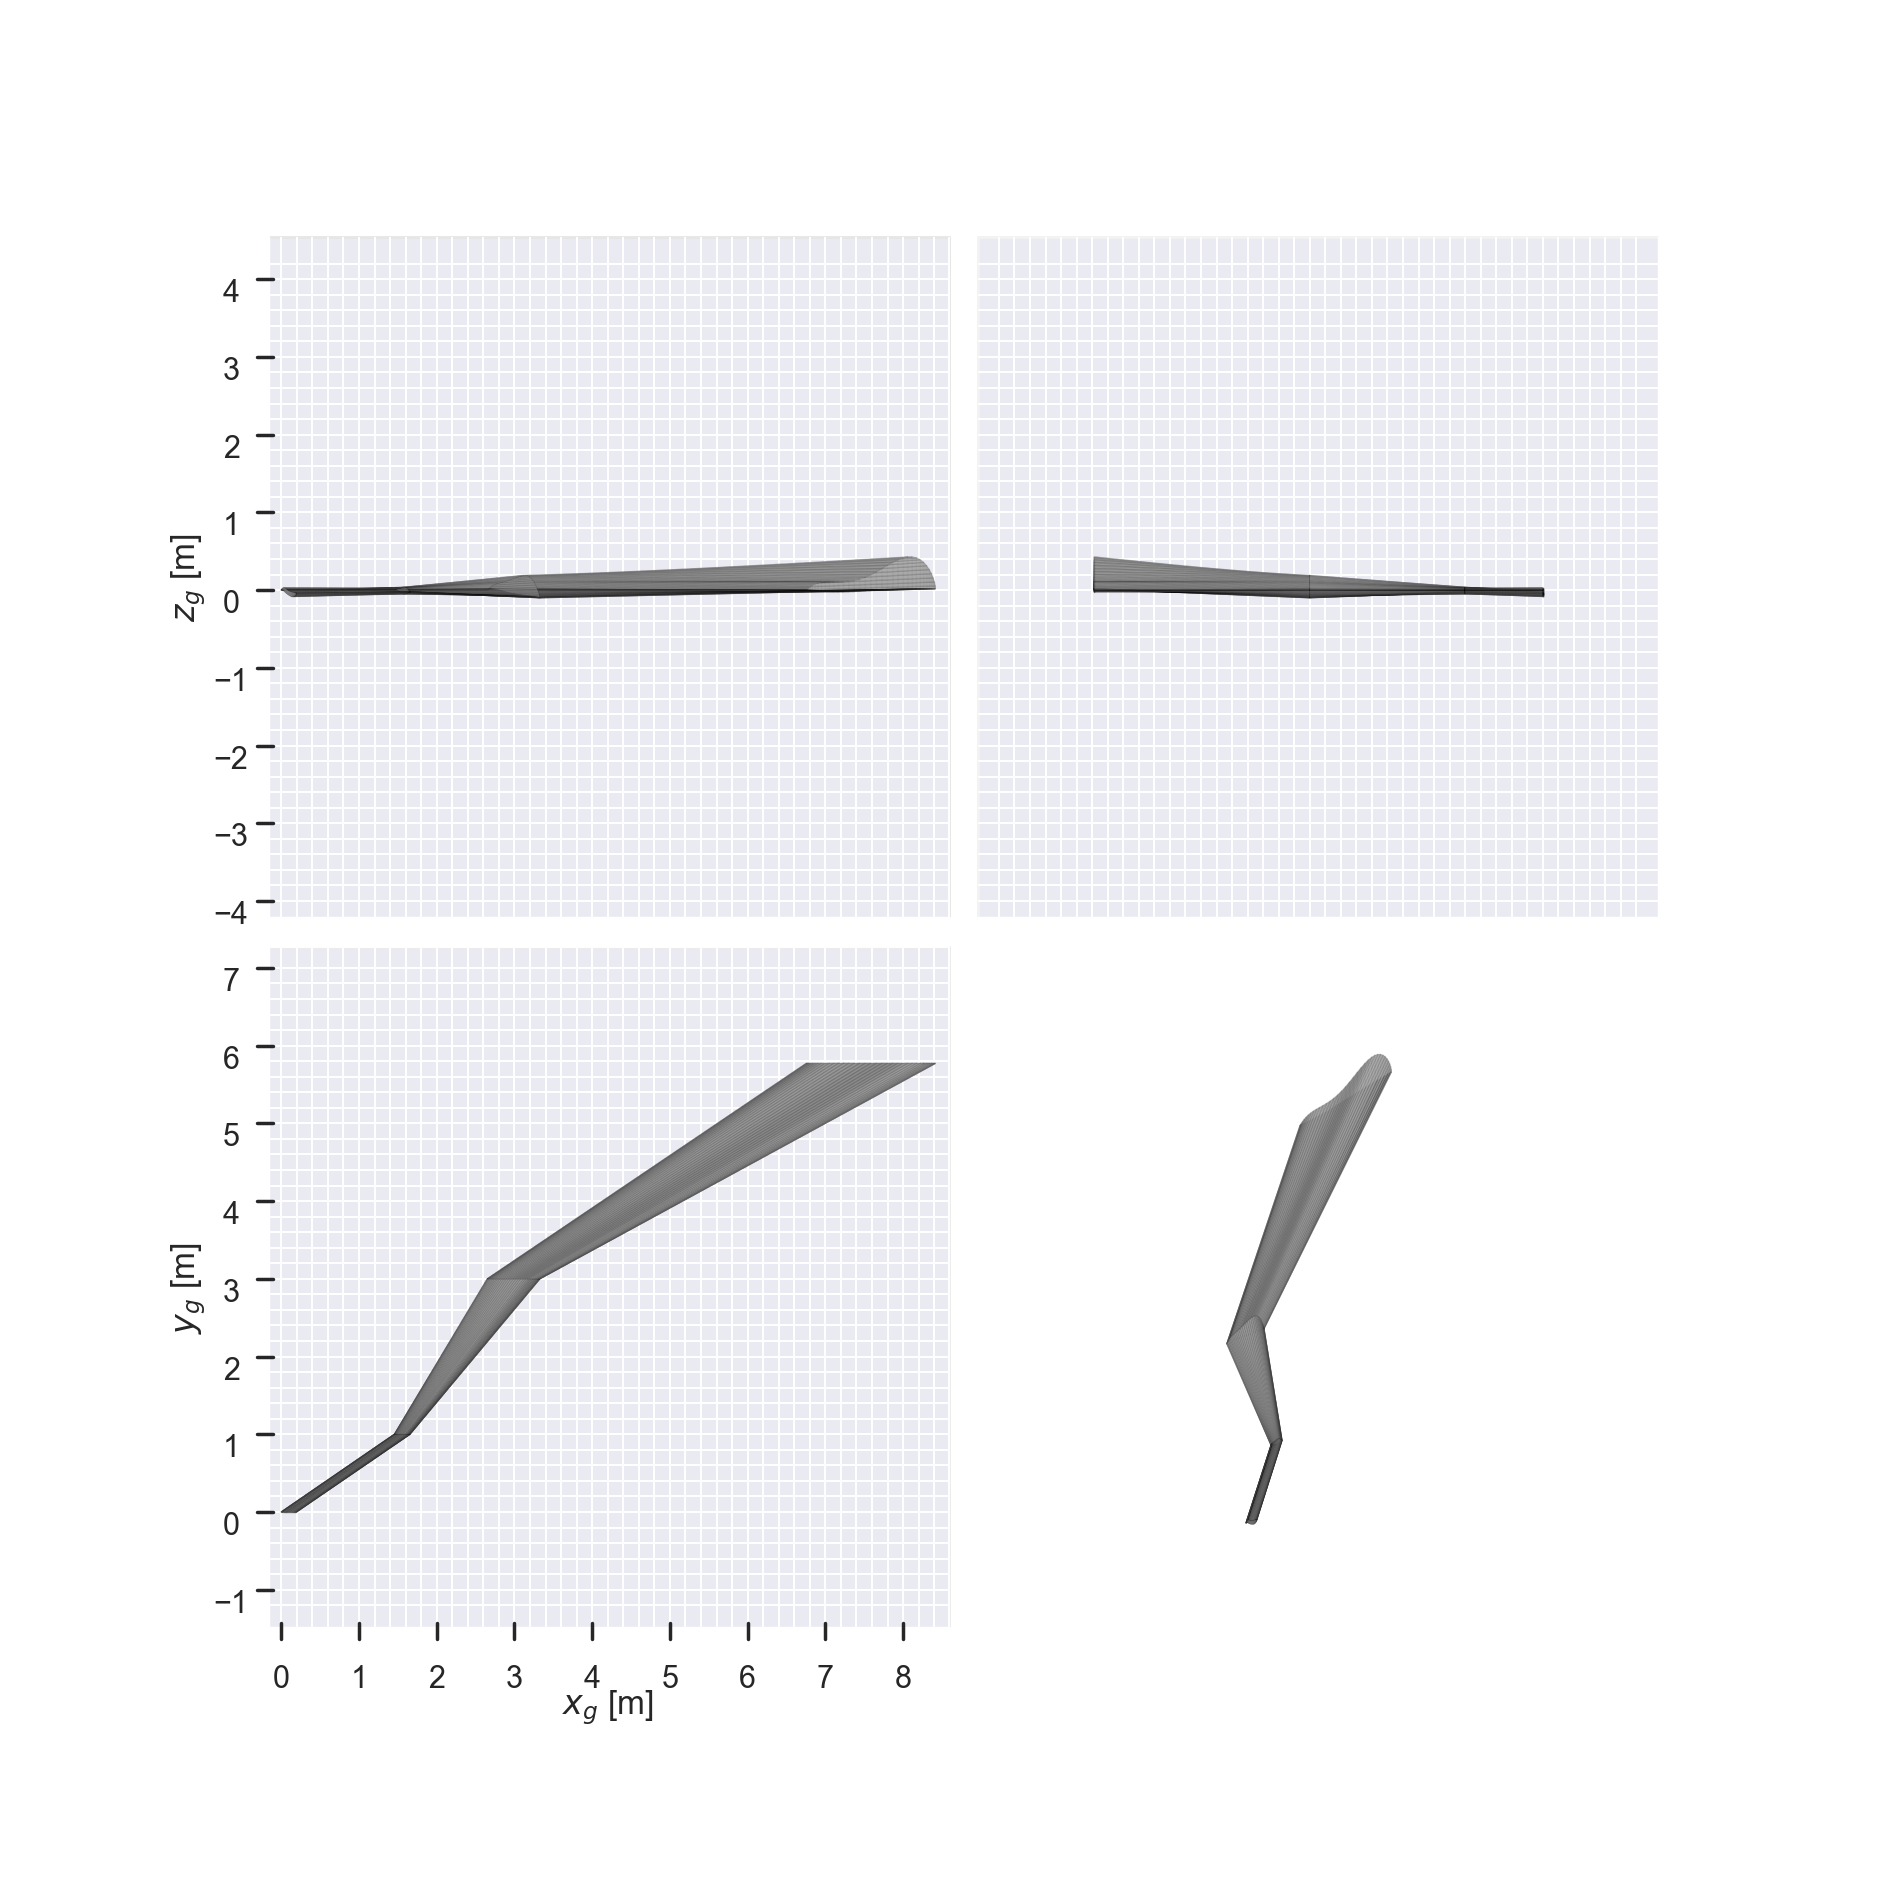

Reset was called!
Torque on Z: -229.68
Torque Penalty: 3.38
Lift: -397.142
Drag: 95.538
Lift/Drag: -4.157
Step: 1/5
Reward: -0.935
Reset was called!
Torque on Z: -9542471298.06
Torque Penalty: 14.28
Lift: 987414253.543
Drag: 7249695231.112
Lift/Drag: 0.136
Step: 1/5
Reward: -0.566
0
Torque on Z: -123.2
Torque Penalty: 2.99
Lift: 265.973
Drag: 12.06
Lift/Drag: 22.055
Step: 2/5
Reward: 3.05
1
Torque on Z: -251.78
Torque Penalty: 3.44
Lift: 766.195
Drag: 33.05
Lift/Drag: 23.183
Step: 3/5
Reward: 7.109
2
Torque on Z: -239.83
Torque Penalty: 3.4
Lift: 623.597
Drag: 21.637
Lift/Drag: 28.821
Step: 4/5
Reward: 16.266
3
Torque on Z: -609.97
Torque Penalty: 3.98
Lift: 1112.417
Drag: 71.225
Lift/Drag: 15.618
Step: 5/5
Reward: 11.634
4
Torque on Z: -88.26
Torque Penalty: 2.78
Lift: 293.988
Drag: 6.058
Lift/Drag: 48.531
Step: 6/5
Reward: 65.875
===






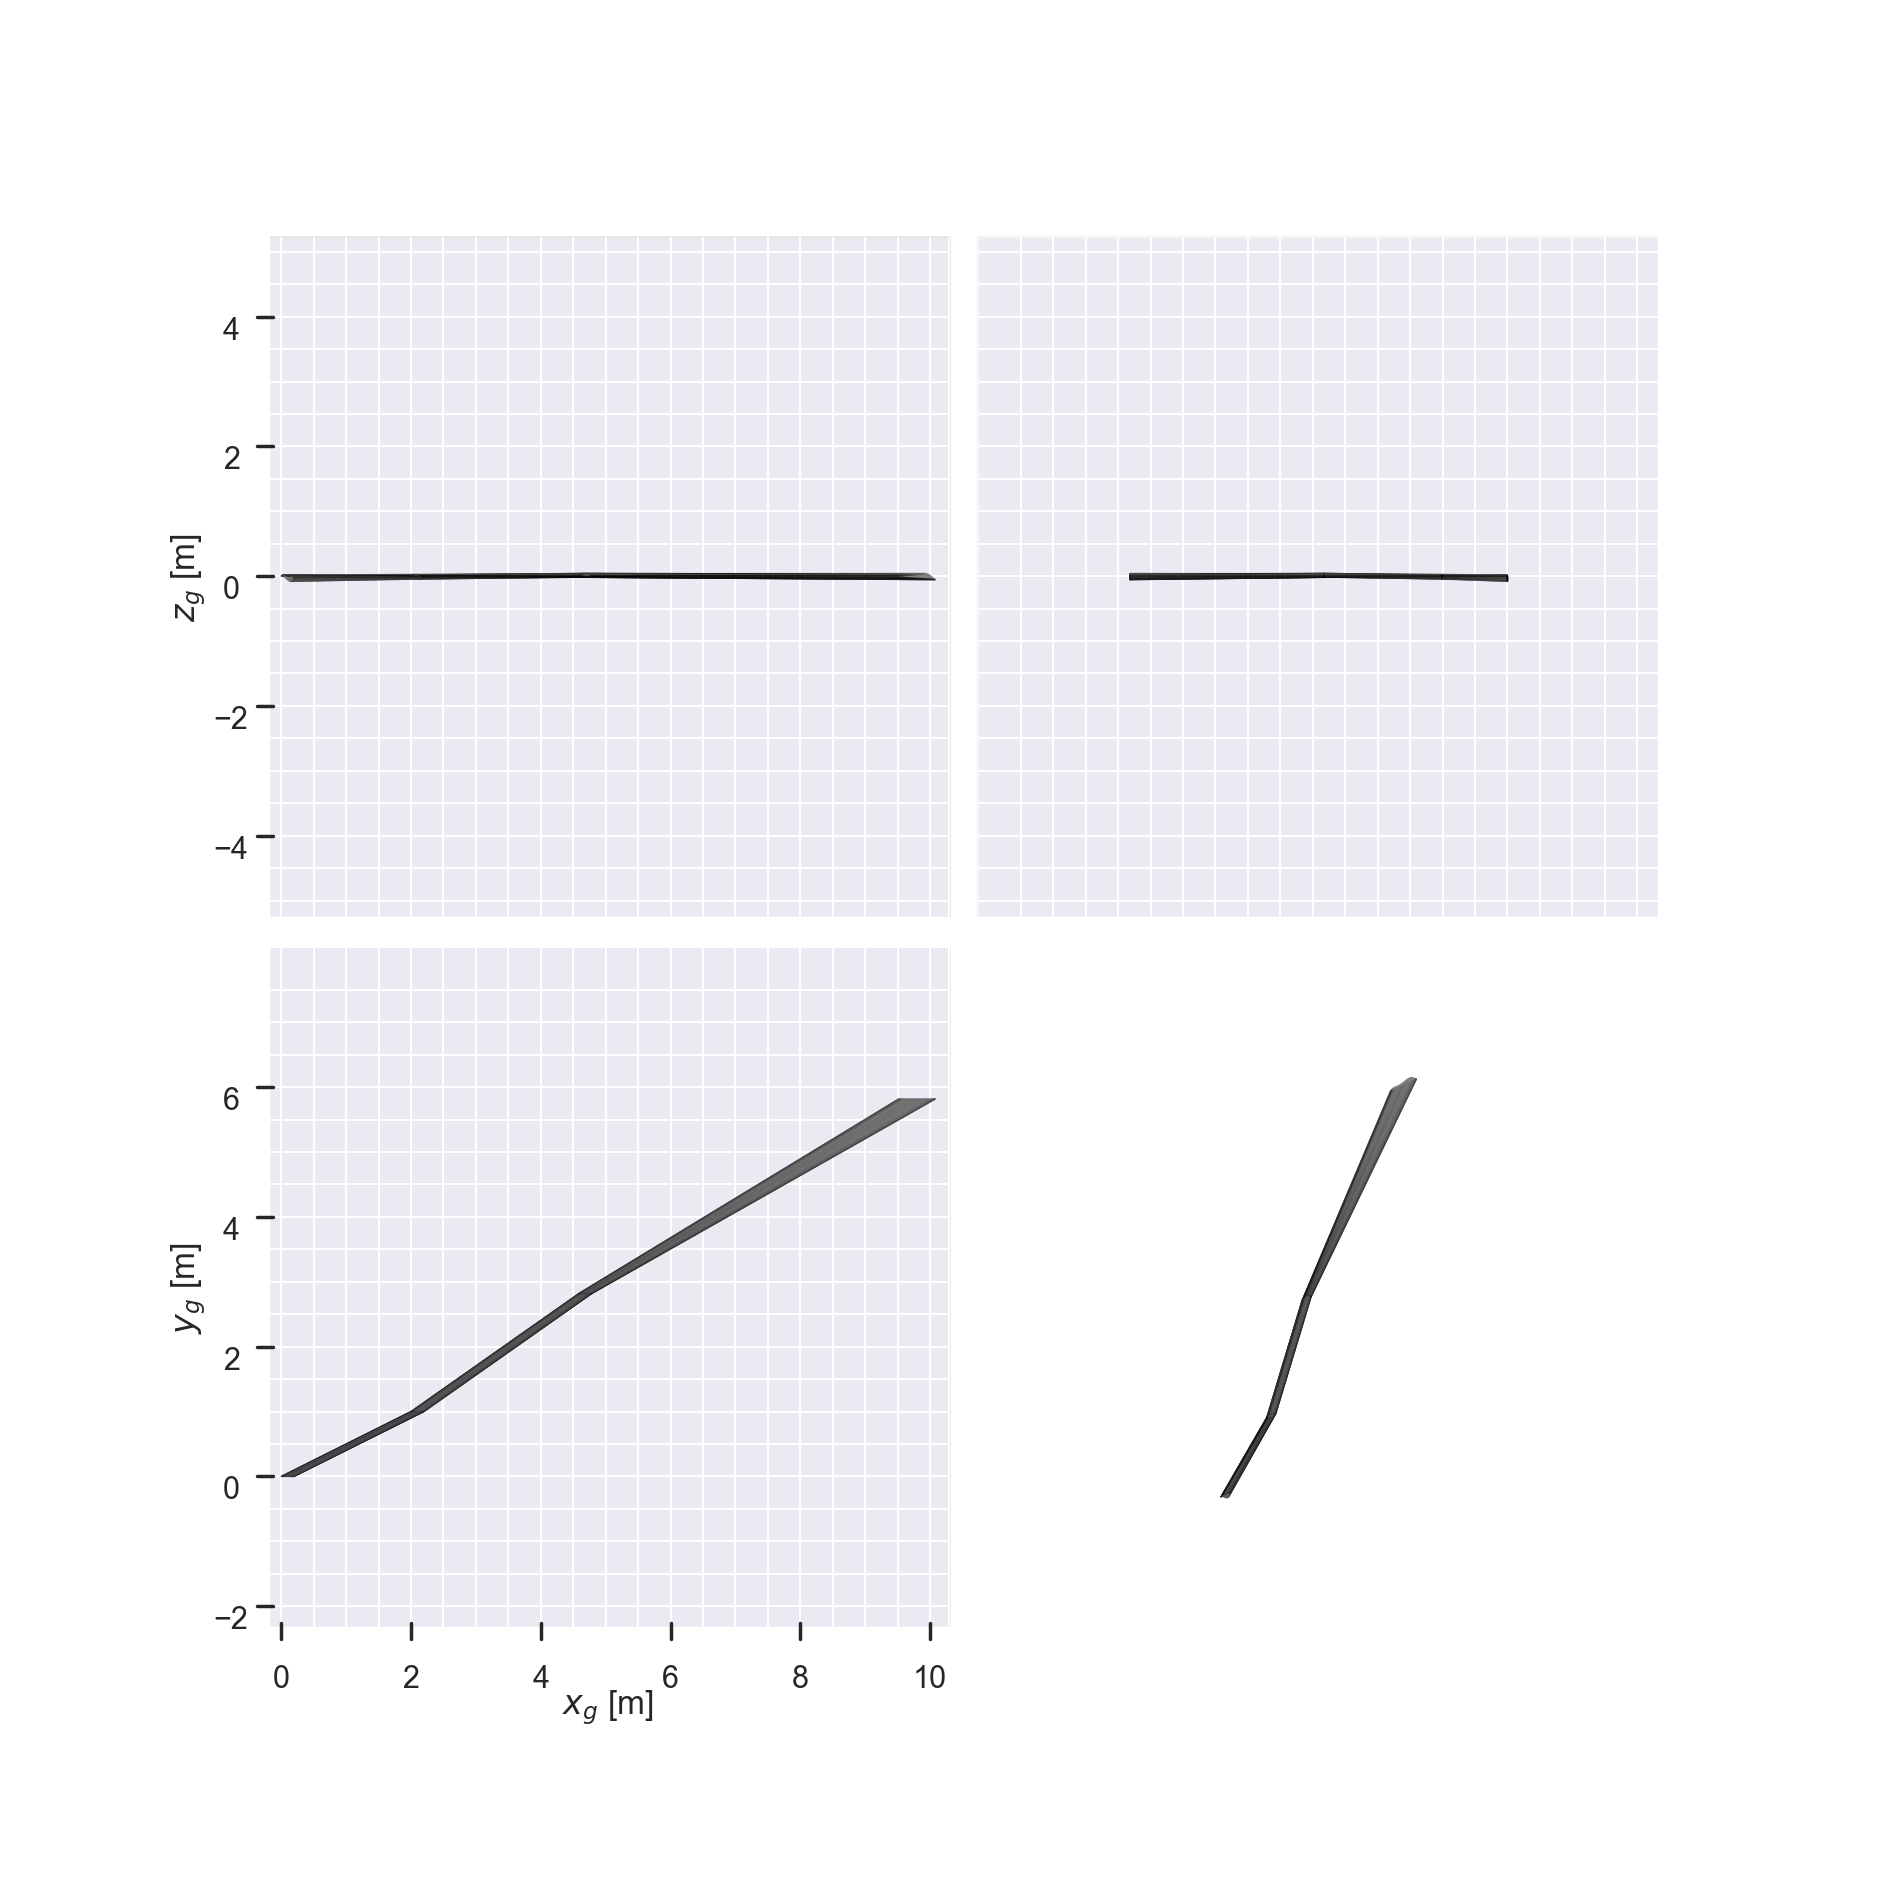

Reset was called!
Torque on Z: 1968832289.53
Torque Penalty: 13.3
Lift: -201396183.18
Drag: 353007656.842
Lift/Drag: -0.571
Step: 1/5
Reward: -50


In [29]:
num_episodes = 10
for _ in range(num_episodes):
    obs, info = env.reset()
    terminated = False
    for i in range(0,steps):
        print(i)
        action, nextHiddenState = model.predict(obs)
        obs, rewards, terminated, truncated, info = env.step(action)
        # if(i%5 == 0):
        #     env.render()
    
    print("===\n\n\n\n")
    env.render()
    env.reset()
env.close()